<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/5_Clustering_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentación de clientes**

Implementación de distintos **algoritmos de clustering** para encontrar segmentos de clientes en función de su patrón de consumo anual en diversas categorías de productos. El dataset contiene el gasto anual y este se extrae de [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler

## **1. Lectura y análisis del dataset**

Para fines académicos, la carga de los datos se hace desde un [repositorio de GitHub](https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/ProjectWC/main.ipynb) propuesto.

In [ ]:
customers = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectWC/data/wholesale_customers_data.csv")
customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


La descripción de las columnas del dataset son las siguientes: 

* **Channel**: Canal de consumo del cliente.
  - 1: Horeca (Hotel/Restaurant/Café)
  - 2: Retail channel (Nominal)

* **Region**: Región de consumo del cliente.
  - 1: Lisnon
  - 2: Oporto
  - 3: Other (Nominal)

* **Fresh**: gasto anual, en unidades monetarias (m. u.), en productos frescos.

* **Milk**: gasto anual, en unidades monetarias (m. u.), en productos lacteos.

* **Grocery**: gasto anual, en unidades monetarias (m. u.), en productos comestibles.

* **Frozen**: gasto anual, en unidades monetarias (m. u.), en productos congelados.

* **Milk**: gasto anual, en unidades monetarias (m. u.), en productos.

* **Detergents_Paper**: gasto anual, en unidades monetarias (m. u.), en productos detergentes y papel.

* **Delicassen**: gasto anual, en unidades monetarias (m. u.), en productos de charcutería.



In [ ]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Tengase en cuenta que las columnas `Channel` y `Region` presentan magnitudes significativamente inferiores que las demás.

Se procede a realizar un análisis exploratorio gráfico de cada variable.

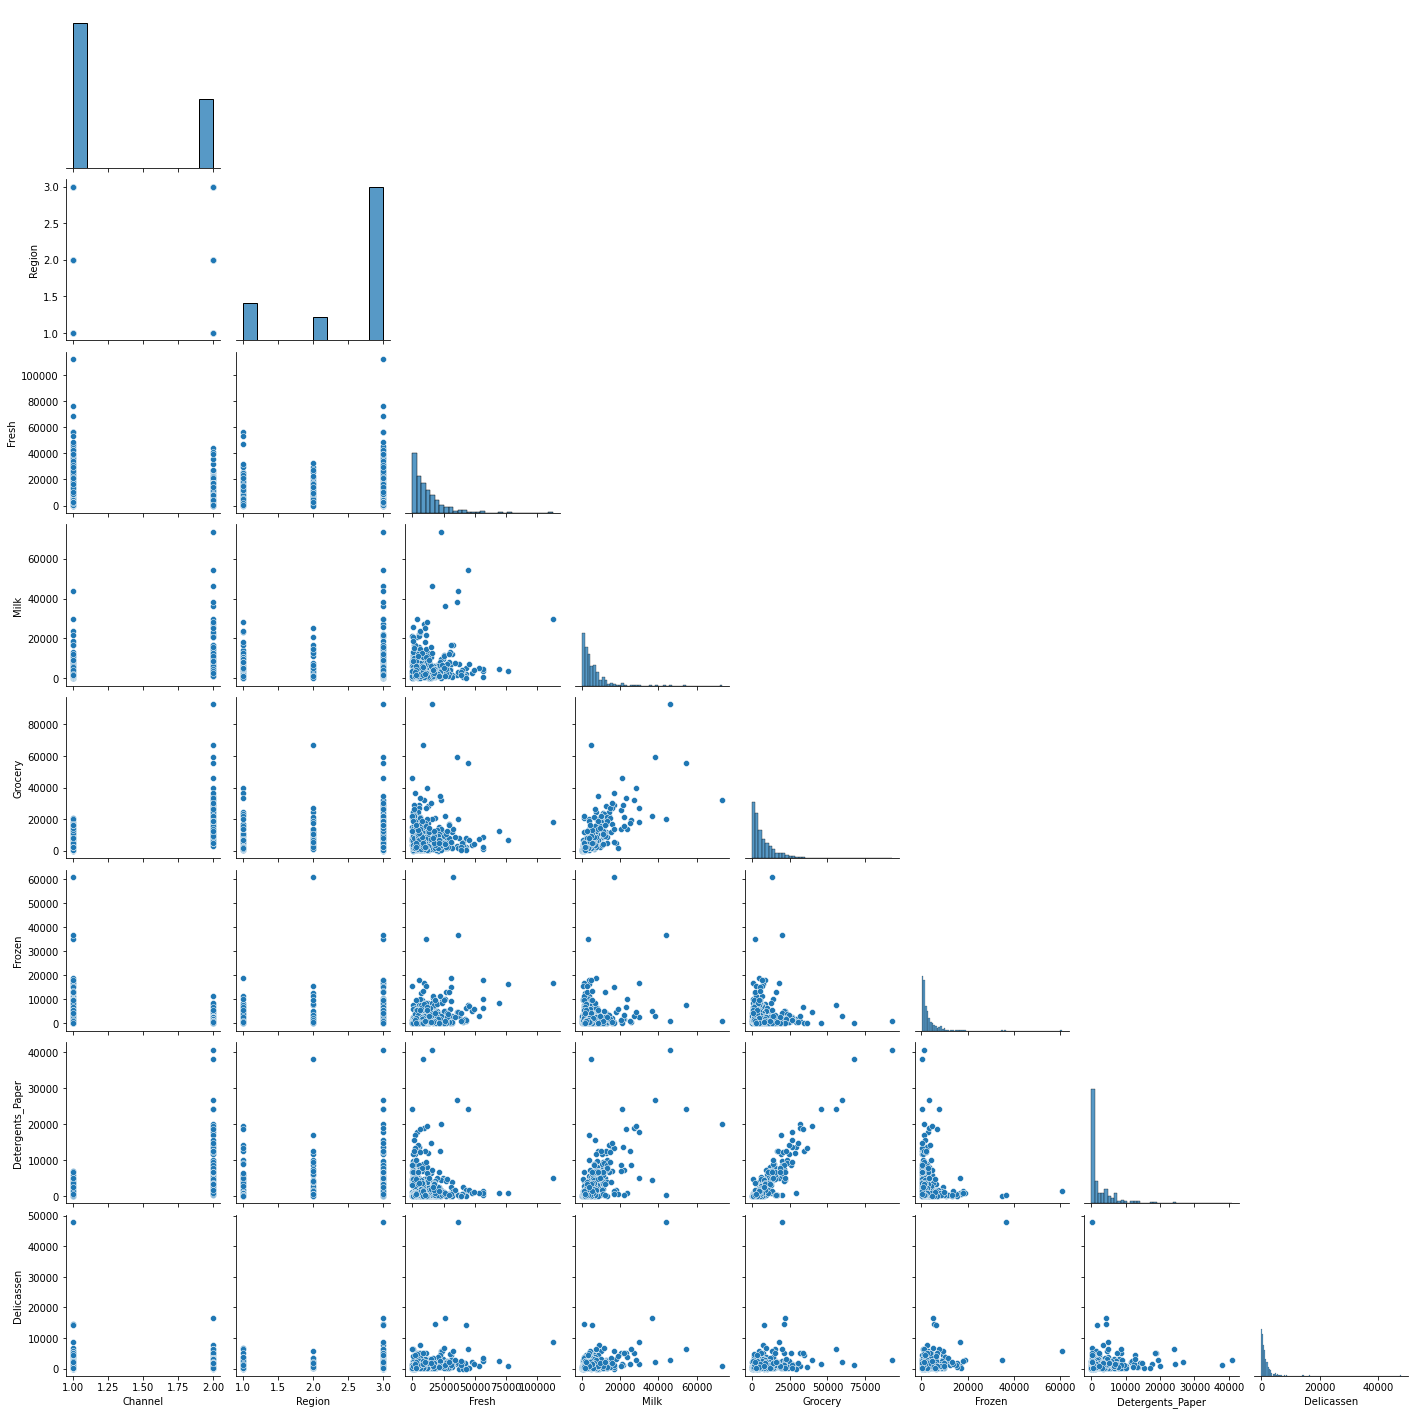

In [ ]:
sns.pairplot(customers, corner=True)
plt.show()

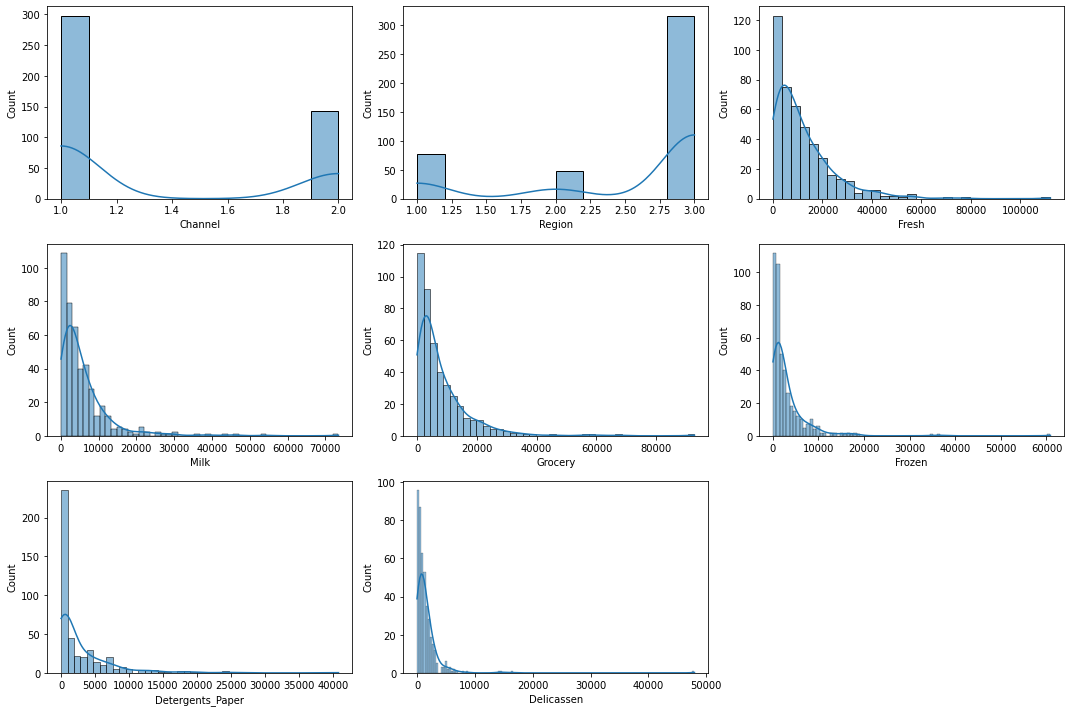

In [ ]:
def hist_grid(dataset, grid_size=(3, 3)):
  fig = plt.figure(figsize=(15,10))
  #fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(0, dataset.shape[1]):
    ax = fig.add_subplot(grid_size[0], grid_size[1], i+1)
    data = dataset.iloc[:,i] if isinstance(dataset, pd.DataFrame) else dataset[:, i]
    sns.histplot(data,ax=ax, kde=True)

  plt.tight_layout()
  plt.show()

hist_grid(customers)

* Los atributos `Channel` y `Region` son variables categóricas con dos y tres valores únicos respectivamente.

* A excepción de las columnas `Channel` y `Region`, las demás presentan una distribución sesgada hacia la derecha.

* Se observa que la mayoría de los datos se encuentran aglomerados para valores inferiores a *20000*. Sin embargo, existen algunos valores alejados de este rango.

## **2. Preparación de los datos**

Se evaluarán distintos algoritmos de agrupamiento con los siguientes datos:

  * **Original**, datos vistos del dataset sin modificación alguna.

  * **Transform**, datos con transformación logarítmica para todas las columnas numéricas y one-hot encoding para los atributos categóricos (`Channel` y `Region`) 

  * **Transform Scaled**, datos transformados de la misma manera descrita en 'Transform' pero estandarizados.

In [ ]:
# All datasets to test
summary = {'Data': {'Original': 0,
                    'Transform': 0,
                    'Transform Scaled': 0},
           
           'Models': {'Original': [],
                      'Transform': [],
                      'Transform Scaled': []},
           
           'Results': {'Original': [],
                       'Transform': [],
                       'Transform Scaled': []}}

### **2.1. Originales**

----------------------------------------
DATOS SIN TRANSFORMACIÓN ALGUNA
----------------------------------------


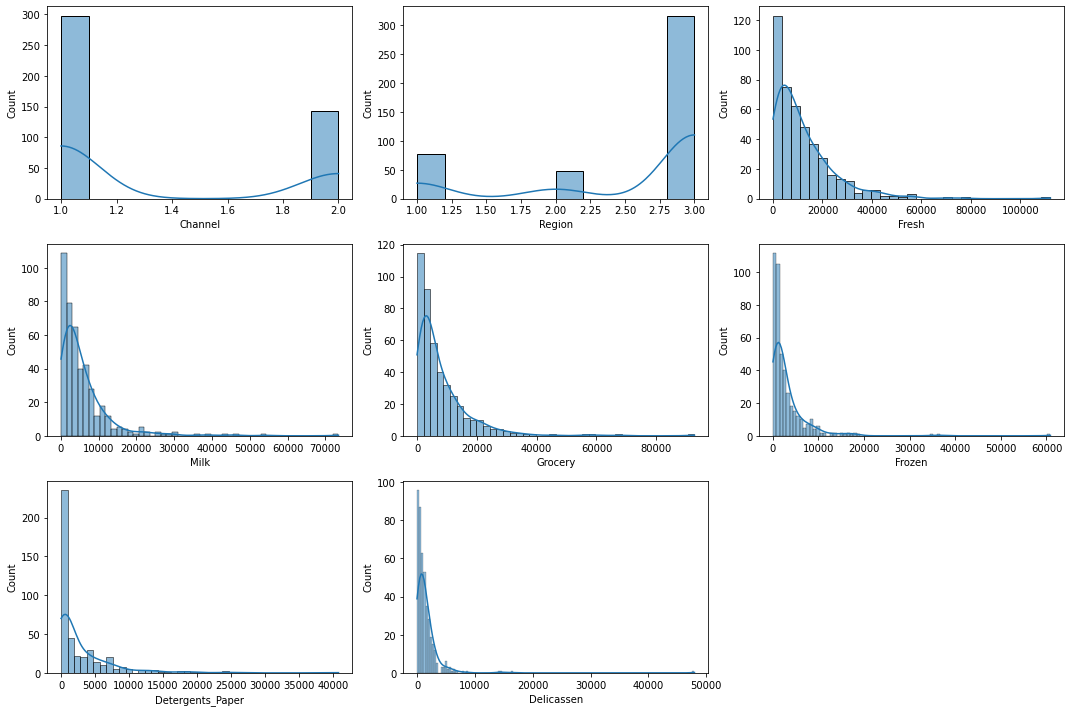

In [ ]:
# Original data
summary['Data']['Original'] = customers

# Visualization
print('-'*40)
print('Datos sin transformación alguna'.upper())
print('-'*40)
hist_grid(summary['Data']['Original'])

### **2.2. Transformados**

----------------------------------------
DATOS TRANSFORMADOS
----------------------------------------


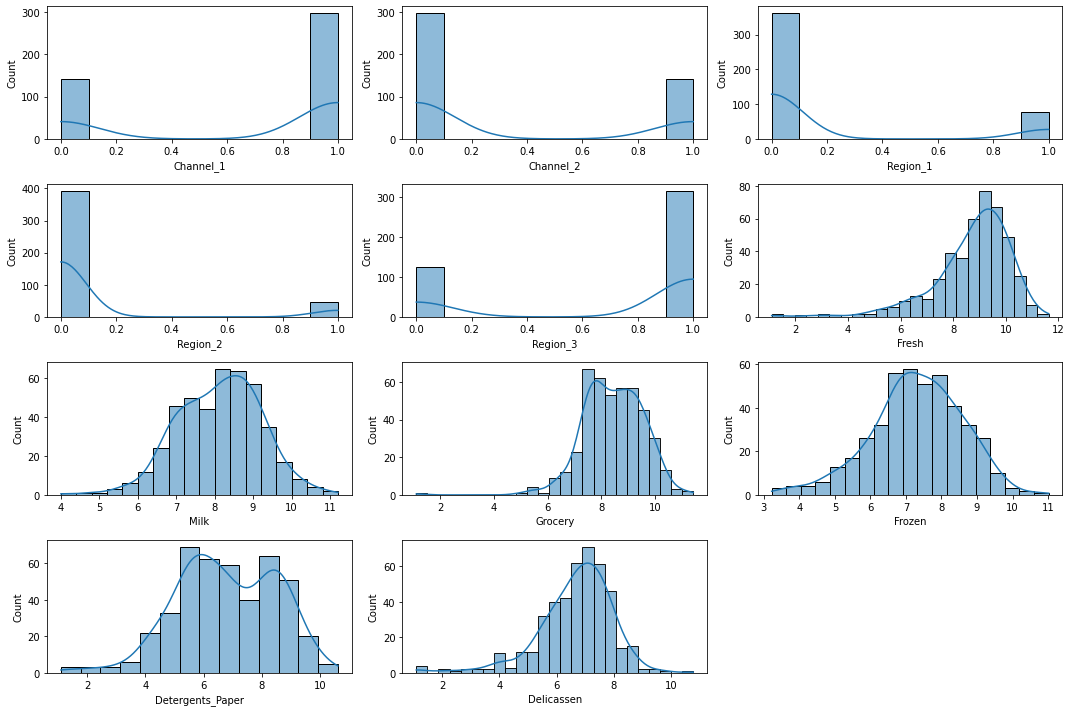

In [ ]:
# Log transform
log_columns = customers.columns[2:]
log_features = np.log(customers[log_columns])

# One-hot encoding
categorical_features = pd.get_dummies(customers.iloc[:, 0:2], columns=['Channel', 'Region'], prefix=['Channel', 'Region'])

# Creates dataset
summary['Data']['Transform'] = pd.concat([categorical_features, log_features], axis=1)

# Visualization
print('-'*40)
print('Datos transformados'.upper())
print('-'*40)
hist_grid(summary['Data']['Transform'], grid_size=(4, 3))

### **2.3. Transformados y estandarizados**

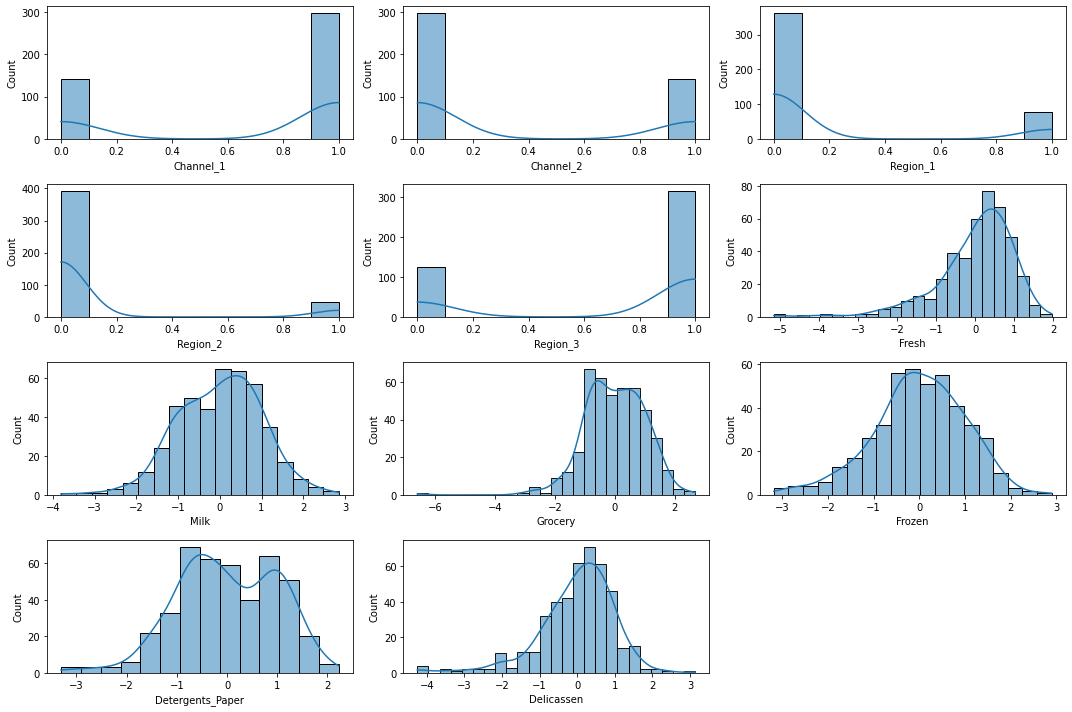

In [ ]:
# Transform and scaled data
transform_data = summary['Data']['Transform']
transform_data.iloc[:, -6:] = StandardScaler().fit_transform(transform_data.iloc[:, -6:])
summary['Data']['Transform Scaled'] = transform_data

hist_grid(summary['Data']['Transform Scaled'], grid_size=(4, 3))

Ahora, observese la distribución de los datos transformados y la relación entre cada uno de ellos.

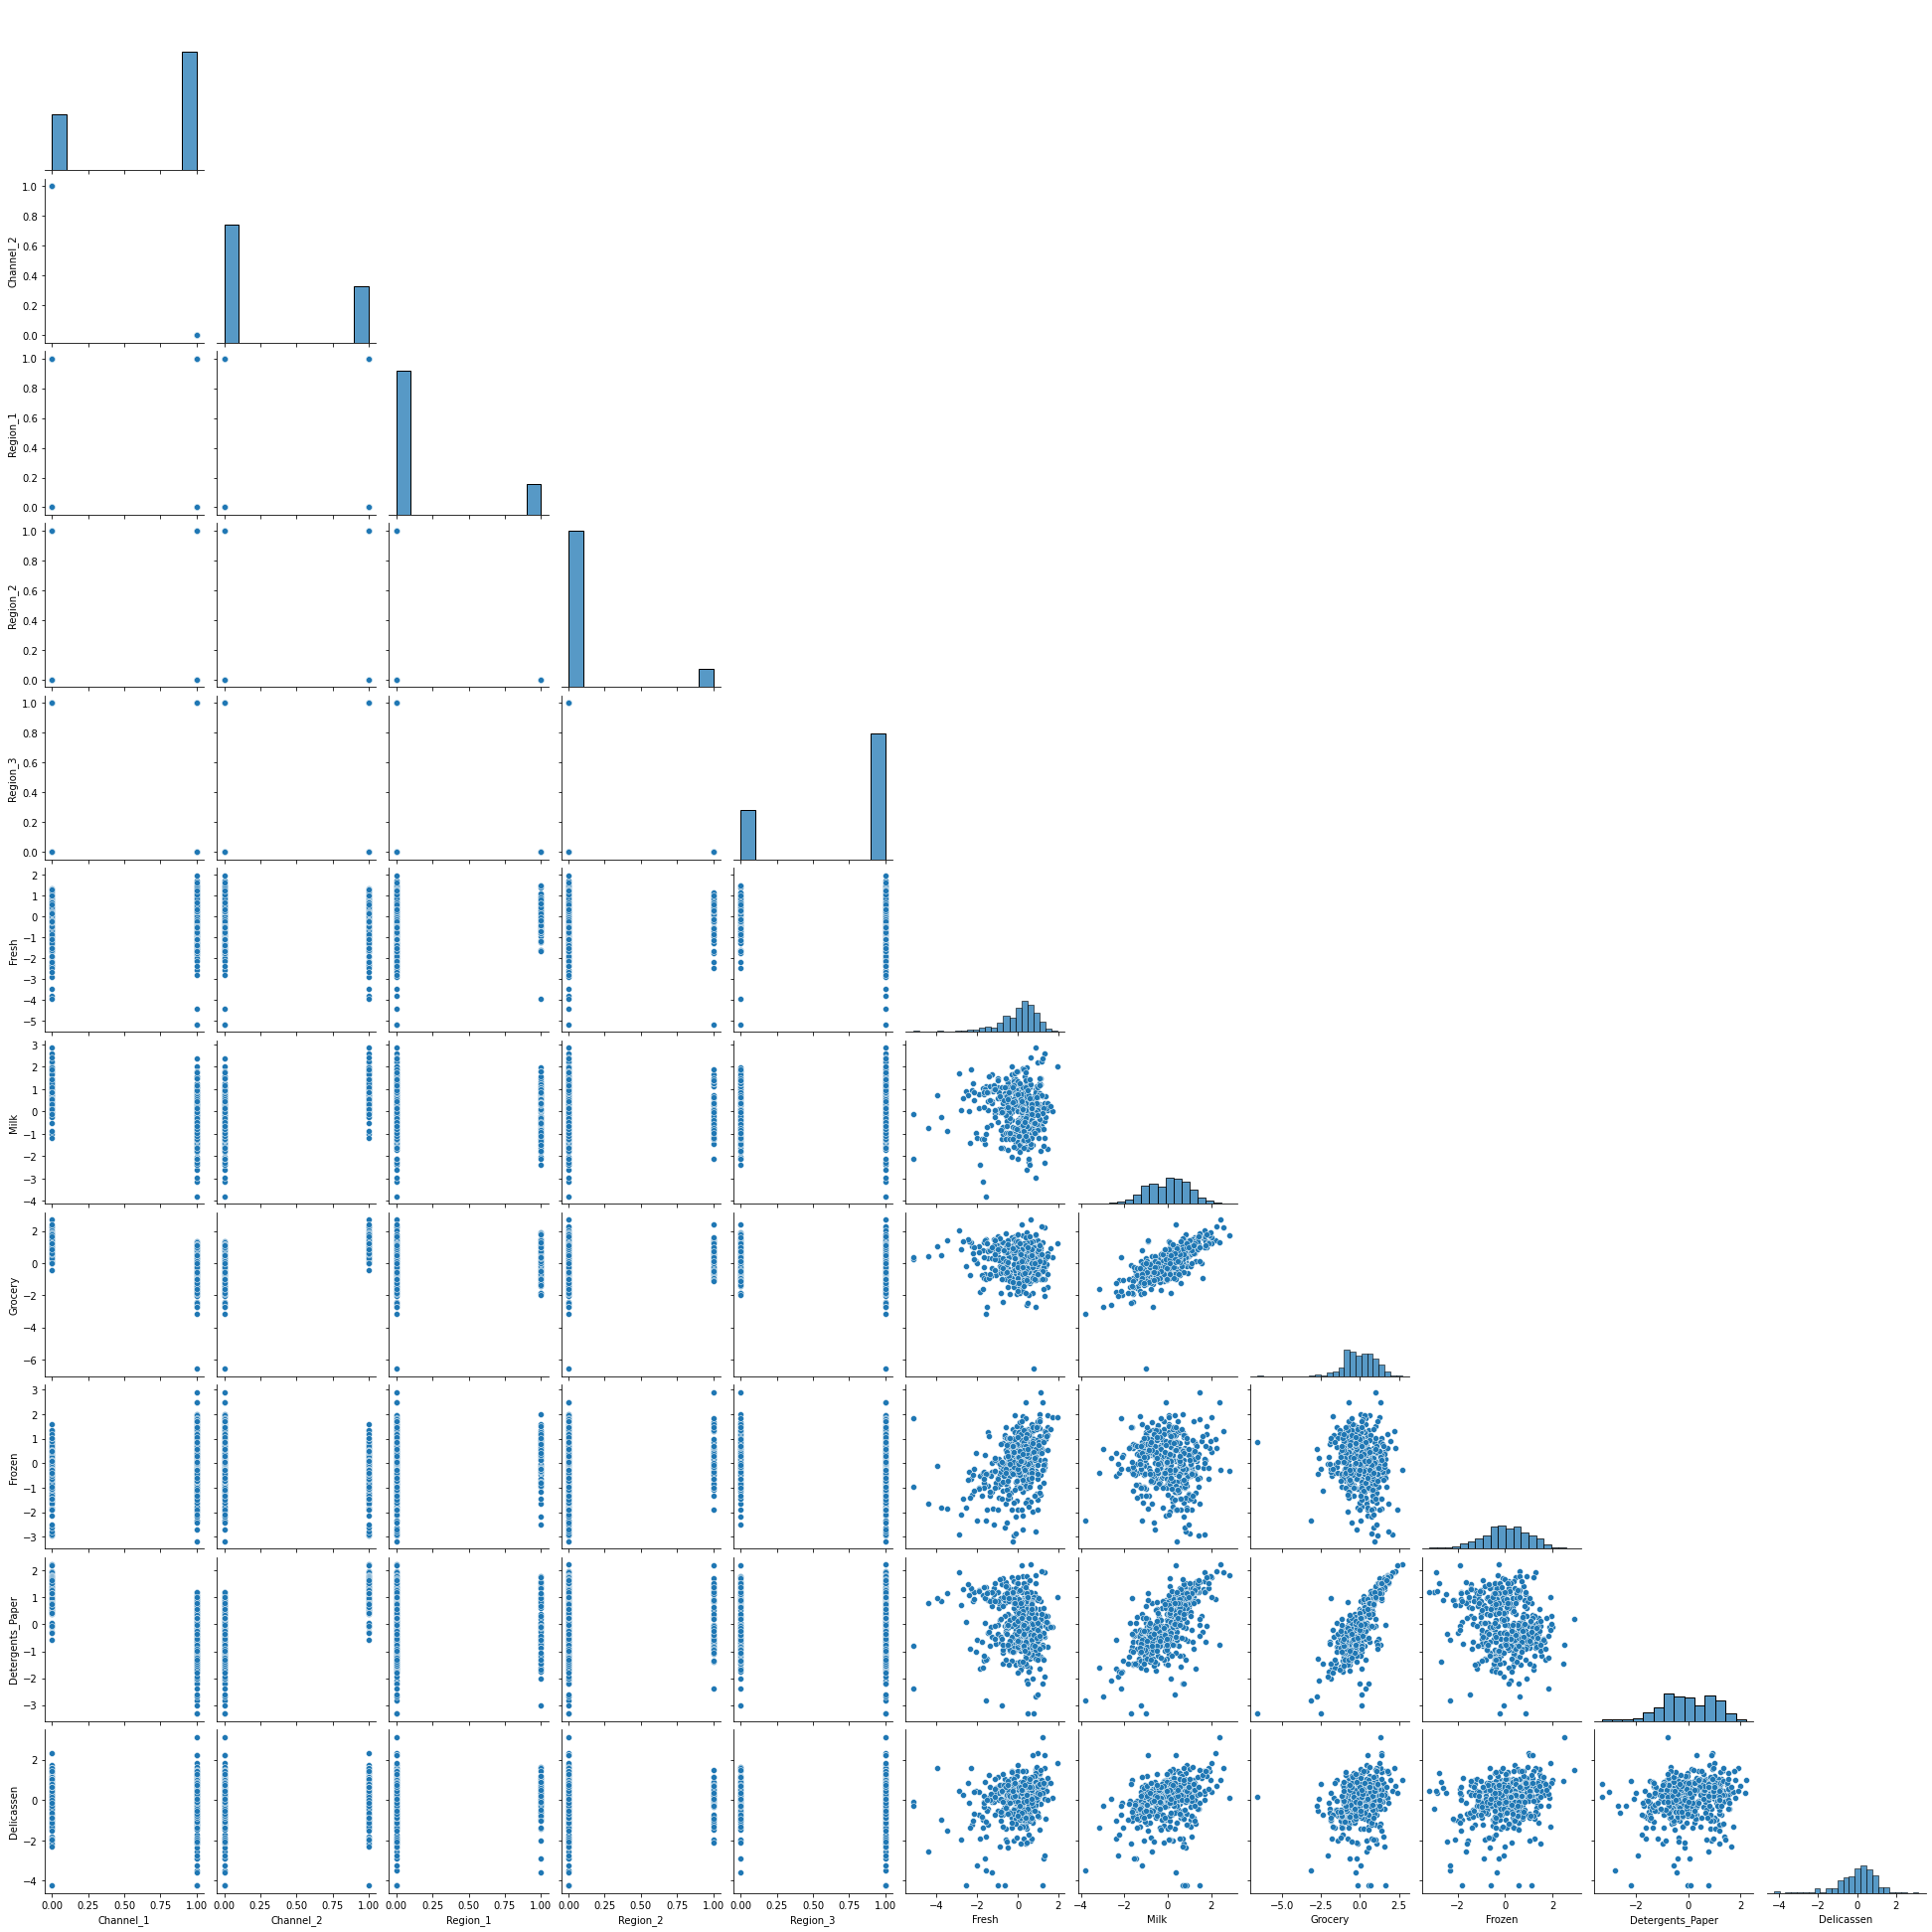

In [ ]:
sns.pairplot(summary['Data']['Transform'], corner=True)
plt.show()

## **3. Algoritmos de Clustering**

Preparados los datos con los que se realizarán las pruebas, se proceden a implementar los siguientes algoritmos de agrupamiento.

  1. K-Means
  2. DBSCAN
  3. Gaussian Mixture Model (GMM)



### **3.1. K-means**

  1. **Definición**

  > The algorithm clusters data by trying to separate samples in `n` groups of equal variance, minimizing a criterion known as the `inertia` or within-cluster sum-of-squares. ([Sklearn Guide](https://scikit-learn.org/stable/modules/clustering.html#k-means))

  2. **Parámetros**

  La creación de los clusters depende directamente de la cantidad de clusters `n_clusters` que el usuario desee.

  3. **Estimación de parámetros**

  Se evalua la suma de las distancias al cuadrado de los datos a su centro de conglomerado más cercano (`inercia`) y se observa el punto donde se encuentra la forma de un codo (`Elbow method`).

Dado lo anterior, primero se realiza una prueba del modelo para cada dataset y cluster en el rango [1, 10]. Luego se observan los valores de inercia para cada caso.

In [ ]:
from sklearn.cluster import KMeans

def get_inertias(X):
  '''
  Creates a K-Mean model for each number of clusters in range [1, 10] and 
  returns the inertia values of every model
  '''

  # Inertia values for each K-Means model
  inertias = []

  # Range of clusters to test for the model
  clusters = range(1, 10 + 1)

  for k in clusters:
    dummy_model = KMeans(n_clusters=k, random_state=23).fit(X)
    inertias.append(dummy_model.inertia_)

  return inertias

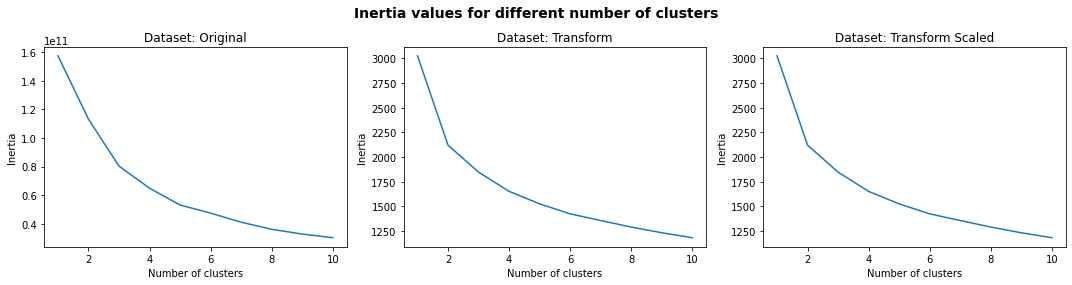

In [ ]:
# Inertias of each K-Means model for each dataset
kMeans_inertias = {}

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axis_index = 0
for dataset_name, dataset in summary['Data'].items():
  
  inertias = get_inertias(dataset)
  kMeans_inertias[dataset_name] = inertias

  axs[axis_index].plot(range(1, len(inertias) + 1), inertias)
  axs[axis_index].set_title('Dataset: ' + dataset_name)
  axs[axis_index].set_xlabel('Number of clusters')
  axs[axis_index].set_ylabel('Inertia')

  axis_index += 1

fig.suptitle(f'Inertia values for different number of clusters', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.show()

* Se puede observar que el valor óptimo, basado en la inercia de cada modelo, se encuentra entre el cluster 4 y 5.

Se realizará la misma gráfica, pero esta vez se le añade un coeficiente proporcional  a la cantidad de clusters para observar mejor el valor del cluster óptimo.

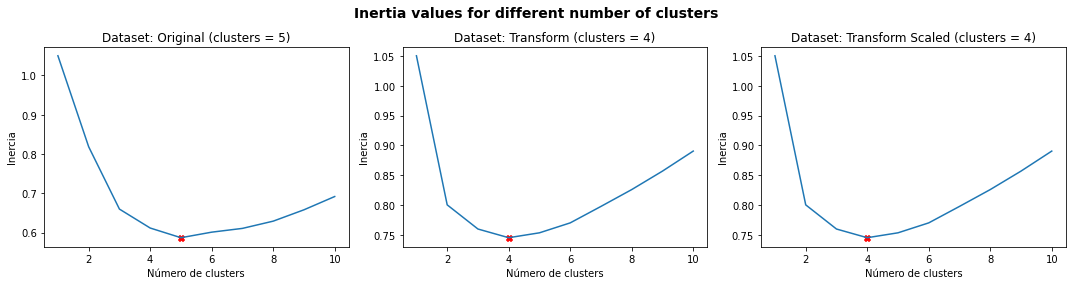

In [ ]:
optimal_clusters = {}

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axis_index = 0
for dataset_name, inertias in kMeans_inertias.items():

  values = []
  alpha_k = 0.05
  n_clusters = len(inertias)

  for k in range(1, n_clusters + 1):
    values.append(inertias[k-1] / inertias[0] + alpha_k * k)

  min_value_index = np.argmin(values)
  optimal_clusters[dataset_name] = min_value_index + 1

  axs[axis_index].scatter(min_value_index + 1, values[min_value_index], c='red', marker='X')
  axs[axis_index].plot(range(1, n_clusters + 1), values)
  axs[axis_index].set_title(f'Dataset: {dataset_name} (clusters = {min_value_index + 1})')
  axs[axis_index].set_xlabel('Número de clusters')
  axs[axis_index].set_ylabel('Inercia')

  axis_index += 1

fig.suptitle(f'Inertia values for different number of clusters', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.show()

* Relacionado con lo anteriormente analizado, se obtiene que para el dataset original el valor óptimo es 5, mientras que para los otros dos es de 4.

Con esto se procede a crear el modelo óptimo y guardarlo para cada dataset correspondiente.

In [ ]:
for dataset_name, n_clusters in optimal_clusters.items():
  X = summary['Data'][dataset_name]
  model = KMeans(n_clusters=n_clusters, random_state=23).fit(X)
  summary['Models'][dataset_name].append(model)

### **3.2. DBSCAN**

1. **Definición**
> A cluster is therefore a **set of core samples**, each close to each other (measured by some distance measure) and a **set of non-core samples** that are close to a core sample (but are not themselves core samples). [(DBSCAN user guide by Sklearn)](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

2. **Parámetros**

  La desición, de si un punto (una observación/muestra del dataset) pertenese o no a un cluster, se basa a partir de los parámetros `eps` y `min_samples`.

  * `eps`, distancia máxima en la que se consideran dos puntos como vecinos.

  * `min_samples`, cantidad minima de vecinos (puntos a una distancia menor o igual a **eps**) que un punto debe tener para ser considerado como un *core sample*. Esto permite controlar la tolerancia del algoritmo respecto a el ruido.

3. **Estimación de parámetros**

  * Investigaciones previas, sugieren que el parámetro `min_samples` debe ser mayor o igual a la cantidad de *features* del dataset. Algunos criterios plantean que, para datasets de 2 dimensiones, se aplique `min_samples = 4`; caso contrario `min_samples = 2 * num_featues`.

  * Por otro lado, para `eps`, se sugiere ser elegido a aprtir del "codo", ubicado en la gráfica de las distancias entre los K-vecinos más cercanos.
> The idea is to calculate, the average of the distances of every point to its k-nearest neighbors. The value of *k* will be specified by the user and corresponds to *min_samples*. [(DBSCAN blog)](https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/#method-for-determining-the-optimal-eps-value)

**Links de interés**
* [DBSCAN algorithm animation](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

* [Determining eps of DBSCAN - Forum](https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan)

* [DBSCAN Parameter Estimation - Blog](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd)

Primero se realiza un análisis exploratorio de la distancia media de cada punto en el dataset. 

La cantidad de vecinos cercanos se relaciona con el criterio planteado para `min_samples`.

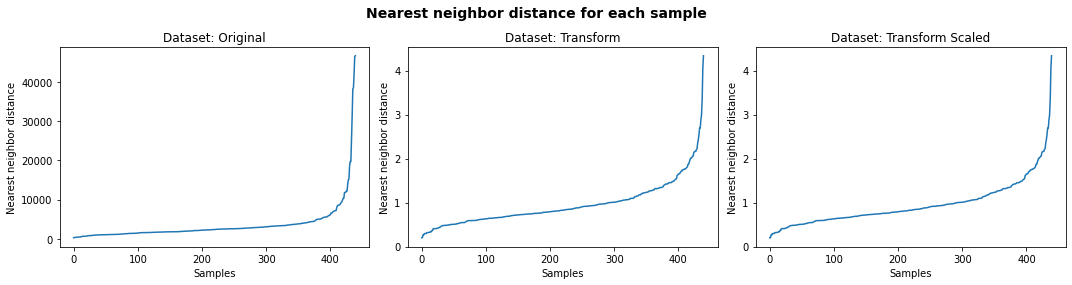

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

nearest_distances = {}

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axis_index = 0

for dataset_name, dataset in summary['Data'].items():

  # Calculates the nbumber of neighbors base on the dataset dimentions
  num_rows, num_cols = dataset.shape
  n_neighbors = 2 * num_cols if num_cols > 2 else 4

  # Get the N-Nearest Neighbors distances
  # You have to set `n_neighbors + 1` because every point in the dataset 
  # is going to be its own nearest neighbor.
  neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(dataset)

  # Gets distances and indices of to the closest `n_neighbors` points
  distances, indices = neighbors.kneighbors(dataset)
  distances = np.sort(distances, axis=0)

  # Get the nearest distance and save it
  distances = distances[:,1]
  nearest_distances[dataset_name] = distances

  axs[axis_index].plot(distances)
  axs[axis_index].set_title(f'Dataset: {dataset_name}')
  axs[axis_index].set_xlabel('Samples')
  axs[axis_index].set_ylabel('Nearest neighbor distance')
  axis_index += 1

fig.suptitle(f'Nearest neighbor distance for each sample', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.show()

Se detalla que la zona de curvatura de las graficas se encuentra desde el punto 350 en adelante. Se procede a realizar un zoom en esa zona.

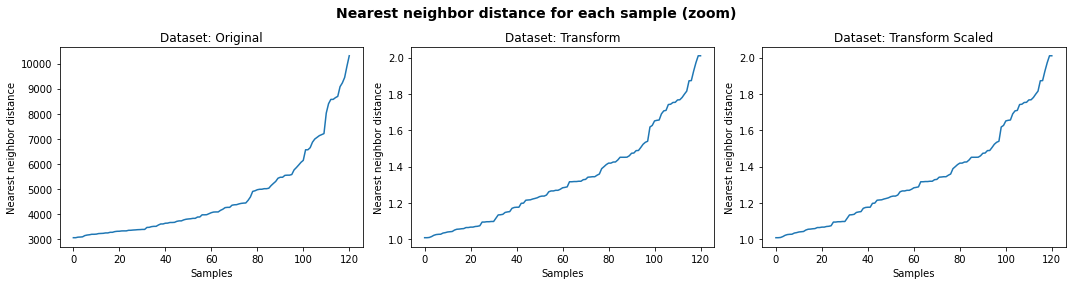

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axis_index = 0

for dataset_name, distances in nearest_distances.items():

  data_zoomed = distances[300:421]

  axs[axis_index].plot(data_zoomed)
  axs[axis_index].set_title(f'Dataset: {dataset_name}')
  axs[axis_index].set_xlabel('Samples')
  axs[axis_index].set_ylabel('Nearest neighbor distance')
  axis_index += 1

fig.suptitle(f'Nearest neighbor distance for each sample (zoom)', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.show()

Según las gráficas ampliadas, se observa que el valor de mayor curvatura (`elbow point = eps`) para cada dataset es el siguiente:

* `Original: 6500`
* `Transform: 1.5`
* `Transform Scaled: 1.5`

Hay que resaltar que la elección de los puntos previos se realiza de manera visual y no es necesariamente el que optimice el modelo.

Se procede a guardar el respectivo modelo para cada dataset.

In [ ]:
optimal_eps = {'Original': 6500, 
               'Transform': 1.5, 
               'Transform Scaled': 1.5}

for dataset_name, eps in optimal_eps.items():
  X = summary['Data'][dataset_name]

  # Calculates the `min_samples` base on the dataset dimentions
  num_rows, num_cols = X.shape
  min_samples = 2 * num_cols if num_cols > 2 else 4

  model = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
  summary['Models'][dataset_name].append(model)

### **3.3. Gaussian Mixture**

  1. **Definición**
  > The GaussianMixture object implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. ([Sklearn Guide](https://scikit-learn.org/stable/modules/mixture.html#gaussian-mixture))

  2. **Parámetros**
    * `n_components`,  representa el número de componentes del algoritmo, es decir de clusters (grupos).

    * `covariance_type`, describe el tipo de parámetros de covarianza:

      * *'full'*, todos los componentes tienen su propia matriz de covarianza.

      * *'tied'*, todos los componentes tienen la misma matriz de covarianzas.

      * *'diag'*, cada componente tiene su propia diagonal en la matriz de covarianzas.

      * *'spherical'*, cada componente tienen su propia varianza.

  3. **Estimación de parámetros**

  Al igual que los modelos anteriores, una de las formas de estimar el valor apropiado de clusters es probar con diferentes valores y evaluar cada uno. 

  Existe dos parámetros de evaluación populares que favorece la maximización la funcion de similitud. 
  
    * Akaike information criterion (AIC)
    * Bayesian information criterion (BIC)

**Links de interés**

* [Gaussian Mixture for clustering | Blog](https://towardsdatascience.com/gaussian-mixture-models-for-clustering-3f62d0da675)

* [Selecting the number of components for GMM | Blog](https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4)

Se procede a crear un modelo `GaussianMixture` con cada dataset para un rango de `n_components` de 2 a 20 y los cuatro tipos de `covariance_type`.

Luego, se calcula para cada cantidad de componentes el parámetro AIC ya que, a comparación de BIC, tiende a ajustarse un poco mejor a los datos.

In [ ]:
# EXECUTION TIME: 3min

from sklearn.mixture import GaussianMixture

# Set up a range of cluster numbers to try [2, 10]
# and types of covariance matrices
components = range(2,21)
covariance_types = ["spherical", "tied", "diag", "full"]

# Summary of all combinations fro Gaussian Mixture (GM)
GM_information = {}

# Test the model for each dataset
for dataset_name, dataset in summary['Data'].items():

  # Create the key for each `dataset_name` and
  # assign an empty dictionary to it
  GM_information[dataset_name] = {}

  # Loop through the covariance types
  for covariance_type in covariance_types:

    # Create the key for each `covariance_type` and 
    # assign an empty list to it
    GM_information[dataset_name][covariance_type] = []

    # Create empty lists to store the AIC values
    aic_scores = []

    # Loop through the range of `n_components`
    for n in components:
      
      model = GaussianMixture(n_components=n, 
                              covariance_type=covariance_type, 
                              random_state=23, 
                              n_init=10).fit(dataset)
      
      # Append the AIC to the respective list
      aic_scores.append(model.aic(dataset))
  
    # Save the result for the `covariance_type` param in the `dataset_name`
    GM_information[dataset_name][covariance_type] = aic_scores

Los resultados de la ejecución se guardan en la variable `GM_information`, con la siguiente estructura:

```
GM_information = {'Original': {'spherical': <aic_scores>,
                               'tied': <aic_scores>,
                               'diag': <aic_scores>},

                  'Transform': {'spherical': <aic_scores>,
                                'tied': <aic_scores>,
                                'diag': <aic_scores>},

                  'Transform Scaled': {'spherical': <aic_scores>,
                                       'tied': <aic_scores>,
                                       'diag': <aic_scores>}}
```

Ahora se grafican los resultados con el puntaje AIC normalizado para propósitos comparativos.

In [ ]:
def plot_gm_information(covariance_types=None, normalize=True, zoomed=None):
  '''
  covariance_type: list of strings
                   name of the covariance types to plot.
  
  normalized: bool
              whether to normalized or not the AIC scores.
  
  zoomed: tuple
          'x' axis ranges for zoom the data.
  '''  
  fig, axs = plt.subplots(1, 3, figsize=(15,4))
  axis_index = 0

  for dataset_name, model_values in GM_information.items():
    # The maximum possible value of the average AIC score 
    # is 1, because its values are normalizing
    min_avg_aic = 100000


    for covariance_type, aic_values in model_values.items():
      # Skip iteration if `covariance_types` is different to 'None' and 
      # if `covariance_type` is not in `covariance_types`
      if (covariance_types) and (covariance_type not in covariance_types):
        continue

      # Normalizes AIC scroes and sets the Y axis label base on `normalize` parameter
      aic_values = aic_values / max(np.abs(aic_values)) if normalize else aic_values
      y_label = 'AIC score normalized' if normalize else 'AIC score'

      # Update minumum params
      if np.mean(aic_values) < min_avg_aic:
        min_avg_aic = np.mean(aic_values)
        min_avg_cov_type = covariance_type

      # Zoom the values if passed as parameter
      # Value in `aic_values` at position 0 means the AIC value for 2 components
      if zoomed:
        aic_values = aic_values[zoomed[0] - 2 : zoomed[1] - 2 + 1]
        num_clusters = range(zoomed[0], zoomed[1] + 1) 
      else:
        num_values = len(aic_values)
        num_clusters = range(2, num_values + 2) 

      axs[axis_index].plot(num_clusters, aic_values, '-o',  label = covariance_type)

    # print('The covariance type with the minimum values is: ' + min_avg_cov_type)

    axs[axis_index].set_title(f'Dataset: {dataset_name} ({min_avg_cov_type})')
    axs[axis_index].set_xlabel('Number of components')
    axs[axis_index].set_ylabel(y_label)
    axs[axis_index].legend()

    axis_index += 1

  fig.suptitle(f'AIC score for Gaussuan Mixture Models', fontsize=14, fontweight="bold")
  plt.tight_layout()
  plt.subplots_adjust(top=0.84)
  plt.show()

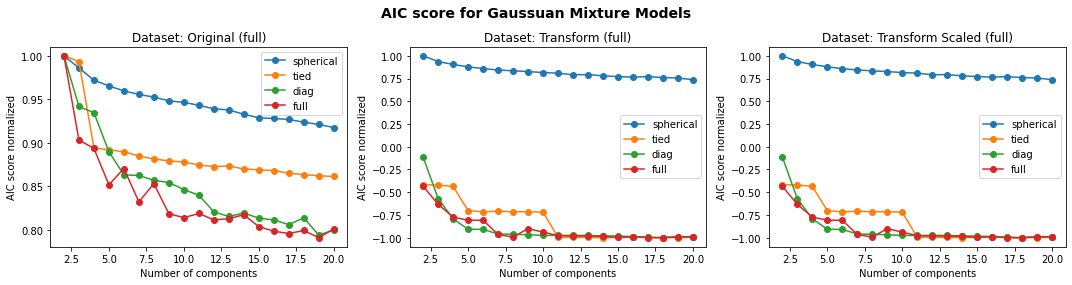

In [ ]:
# Plot results for Gaussian Mixture (GM) model 
plot_gm_information(normalize=True)

* Para los tres datasets, el mejor tipo de covarianza (`covariance_type`) se encuentra entre *'diag'* y *'full'*.

Se procede a graficar solamente esos dos tipos de covarianzas; esta vez no se normalizan los datos y se aplica un zoom en la zona del "codo".

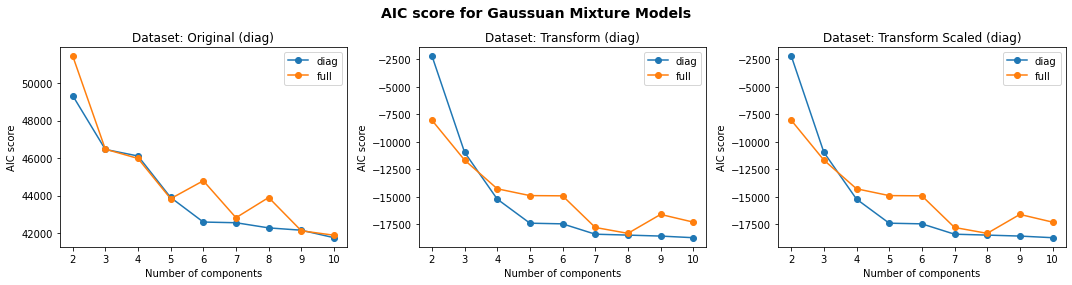

In [ ]:
plot_gm_information(covariance_types=['diag', 'full'], normalize=False, zoomed=(2, 10))

A partir de lo anterior, se observa que el tipo de covarianza (`covariance_type`) con una magnitud inferior de AIC es *'diag'*. 

Por otro lado, la cantidad de componentes (`n_components`) apropiados para cada dataset será el valor al cuál los puntajes de AIC se nivelan después de él. Se asumen los siguientes:

* **Original: 6**
* **Transform: 5**
* **Transform Scaled: 5**

In [ ]:
optimal_components = {'Original': 6, 
                      'Transform': 5, 
                      'Transform Scaled': 5}

for dataset_name, n_components in optimal_components.items():
  
  X = summary['Data'][dataset_name]

  model = GaussianMixture(n_components=n_components, 
                          covariance_type='diag', 
                          random_state=23, 
                          n_init=10).fit(X)

  summary['Models'][dataset_name].append(model)

## **4. Validación de los modelos**

Para evaluar el agrupamiento realizado por cada modeo, se implementa el coeficiente de `Silhouette`.

> The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. [(Silhouette, wikipedia)](https://en.wikipedia.org/wiki/Silhouette_(clustering))


**LINKS**

* [Explanation | Youtube](https://www.youtube.com/watch?v=DpRPd274-0E)
* [Silhouette Coefficient | Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

In [ ]:
# Shows all models per dataset
num_dashes = 70
for dataset_name, models in summary['Models'].items():
  print(dataset_name)
  print('-'*num_dashes)
  # del models[-1]
  for index, model in enumerate(models):
    print(f'{index + 1} - {model}')
  print('-'*num_dashes, '\n\n')

Original
----------------------------------------------------------------------
1 - KMeans(n_clusters=5, random_state=23)
2 - DBSCAN(eps=6500, min_samples=16)
3 - GaussianMixture(covariance_type='diag', n_components=6, n_init=10,
                random_state=23)
---------------------------------------------------------------------- 


Transform
----------------------------------------------------------------------
1 - KMeans(n_clusters=4, random_state=23)
2 - DBSCAN(eps=1.5, min_samples=22)
3 - GaussianMixture(covariance_type='diag', n_components=5, n_init=10,
                random_state=23)
---------------------------------------------------------------------- 


Transform Scaled
----------------------------------------------------------------------
1 - KMeans(n_clusters=4, random_state=23)
2 - DBSCAN(eps=1.5, min_samples=22)
3 - GaussianMixture(covariance_type='diag', n_components=5, n_init=10,
                random_state=23)
--------------------------------------------------------

In [ ]:
def silhouette_plot(X, labels, model, axis):
  '''
  Creates a silhouette plot on `axis` for clustering `model`.

  X: array
     Features to predict labels.

  labels: array
          Labels of the samples in `X`
  
  model: sklearn object
         CLustering algorithm.
  
  axis: matplotlib axis
        Axis to display the silhouette plot.
  '''

  # Get the model name
  model_name = type(model).__name__

  # Get the predicted labels
  # if hasattr(model, "labels_"):
  #   labels = model.labels_.astype(int)
  # else:
  #   labels = model.predict(X)
  
  # Takes samples with positive number of cluster (negative values in 
  # some models means samples with no cluster)
  X = X[labels >= 0] if (labels < 0).any() else X
  labels = labels[labels >= 0] if (labels < 0).any() else labels

  # Checks that there is more that 1 cluster
  if len(np.unique(labels)) > 1:

    # The `silhouette_score` gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for label in np.unique(labels):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[labels == label]
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(label+1) / len(np.unique(labels)))
      axis.fill_betweenx(y=np.arange(y_lower, y_upper),
                              x1=0,
                              x2=ith_cluster_silhouette_values,
                              facecolor=color,
                              edgecolor=color,
                              alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      axis.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

    total_negatives = sample_silhouette_values[sample_silhouette_values<0].shape[0]
    axis.set_title(f'{model_name}\n (avg={round(silhouette_avg, 3)}, negatives={total_negatives})')
    axis.set_xlabel("The silhouette coefficient values")
    axis.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axis.axvline(x=silhouette_avg, color="red", linestyle="--")

    axis.set_yticks([])  # Clear the yaxis labels / ticks
    # axs[index].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    min_value = round(float(min(sample_silhouette_values)), 1)
    min_value = min(min_value, -0.1)
    xticks = np.linspace(start=min_value, 
                        stop=round(float(max(sample_silhouette_values)), 1), 
                        num=7)
    axis.set_xticks(np.round(xticks, 2))
  
  else:
    axis.set_title(f'{model_name} (Only 1 cluster found)')
    axis.set_xlabel("Silhouette coefficient")
    axis.set_ylabel("Cluster label")

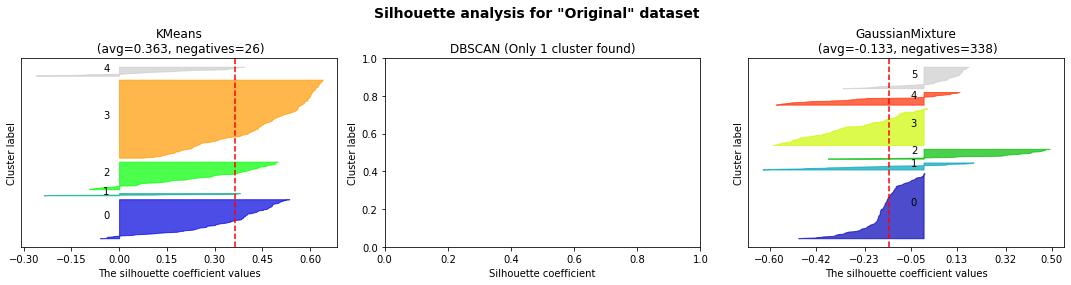

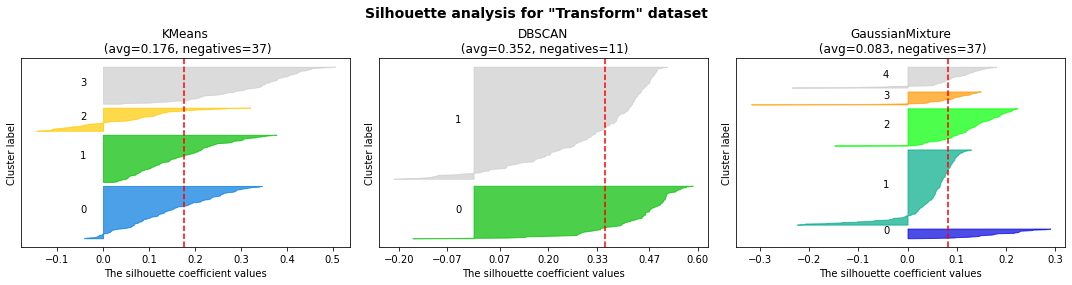

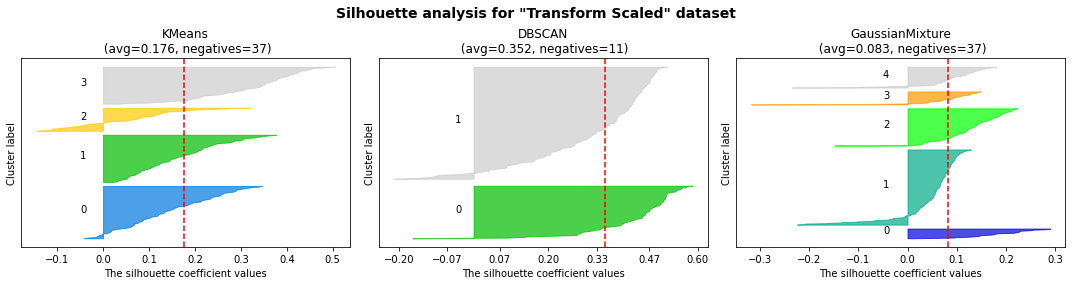

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for dataset_name, dataset in summary['Data'].items():
  
  models = summary['Models'][dataset_name]
  fig, axs = plt.subplots(1, len(models), figsize=(15,4))


  for index, model in enumerate(models):
    # Get the predicted labels
    if hasattr(model, "labels_"):
      labels = model.labels_.astype(int)
    else:
      labels = model.predict(dataset)


    silhouette_plot(X=dataset,
                    labels=labels, 
                    model=model, 
                    axis=axs[index])

  fig.suptitle(f'Silhouette analysis for "{dataset_name}" dataset', fontsize=14, fontweight="bold")
  plt.tight_layout()
  plt.subplots_adjust(top=0.8)
  plt.show()

Las gráficas muestran el valor del coeficiente de Silhouette para cada modelo y muestra en el dataset correspondiente. De ellas se puede analizar lo siguiente:

* Para todos los datasets y modelos probados, se obtienen valores del coeficiente negativos, es decir, para todos los casos existen muestras/puntos que no estan correctamente agrupados.

* El modelo `GaussianMixture`, para las pruebas planteadas, es el que peor agrupa los datos para los tres datasets.

* En cuanto a `DBSCAN`, se tiene que tanto para los datos `Transform` y `Transform Scaled` encuentra un total de 2 clusters con un coeficiente de Silhouette relativamente bueno. Sin embargo, nótese que para el dataset `Original` no se logra computar este parámetro de calida, ya que agrupó todas las muestras en un solo cluster.

* Recuerdese que para el algoritmo de `DBSCAN` se puede obtener clusters con valor de *-1*, esto significa que aquellas muestras no fueron asignadas a ningun cluster; para la evaluación del modelo se omiten estos casos.

* Se observa que los resultados para los datasets `Transform` y `Transform Scaled` son iguales. Se podría inferir que la estandarización de los datos no influye para los algoritmos probados.

## **5. Ajuste de parámetros**

Visto los resultados previos, se procede a ajustar los parámetros con rangos basados en lo visualizado en la sección [3]. Sin embargo, esta vez se mostrará el valor del coeficiente de Silhouette para cada valor en el rango especificado y se incluirá el modelo `AgglomerativeClustering`

### **5.1. Modelos**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone

params_grid = {'Original': {'K-Means': {'model': KMeans(random_state=23),
                                        'n_clusters': np.arange(2, 6 + 1)},
                            
                            'DBSCAN': {'model': DBSCAN(min_samples=16),
                                       'eps': np.linspace(start=4000, stop=8000, num=10)}, 
                            
                            'Gaussian Mixture': {'model': GaussianMixture(covariance_type='diag', random_state=23),
                                                 'n_components': np.arange(2, 6 + 1)},
                            
                            'Agglomerative': {'model': AgglomerativeClustering(),
                                              'n_clusters': np.arange(2, 6 + 1)}
                            },
               
               

               'Transform': {'K-Means': {'model': KMeans(random_state=23),
                                        'n_clusters': np.arange(2, 6 + 1)},
                            
                             'DBSCAN': {'model': DBSCAN(min_samples=22),
                                       'eps': np.arange(1.0, 2.0 + 0.1, 0.1)}, 
                            
                             'Gaussian Mixture': {'model': GaussianMixture(covariance_type='diag', random_state=23),
                                                 'n_components': np.arange(2, 6 + 1)},
                            
                             'Agglomerative': {'model': AgglomerativeClustering(),
                                              'n_clusters': np.arange(2, 6 + 1)}
                             },
               


               'Transform Scaled': {'K-Means': {'model': KMeans(random_state=23),
                                                'n_clusters': np.arange(2, 6 + 1)},
                            
                                    'DBSCAN': {'model': DBSCAN(min_samples=22),
                                               'eps': np.arange(1.0, 2.0 + 0.1, 0.1)}, 
                                    
                                    'Gaussian Mixture': {'model': GaussianMixture(covariance_type='diag', random_state=23),
                                                         'n_components': np.arange(2, 6 + 1)},
                                    
                                    'Agglomerative': {'model': AgglomerativeClustering(),
                                                      'n_clusters': np.arange(2, 6 + 1)}
                                    }
               }
               

# Tunning param results
tunning_results = {}

# Loops over each Datasetf
for dataset_name, models_dict in params_grid.items():

  # Creates a `key` for the `dataset_name`
  tunning_results[dataset_name] = {}


  # Model information
  for  model_name, model_data in models_dict.items():

    # Creates a `key` for the `model_name`
    tunning_results[dataset_name][model_name] = {}
    
    # Get the names of each data for the `model_name` model
    model_key, param_name = model_data.keys()

    # Model object
    model_object = model_data[model_key]

    # Parameters of the model
    param_values = model_data[param_name]

    # Features
    X = summary['Data'][dataset_name]


    # Test every param value for one model
    scores = []
    best_score = -1.0
    best_models = []
    for param_value in param_values:
      param_value = round(param_value, 3)

      # Sets the current params and fit the model
      model = clone(model_object)
      model = model.set_params(**{param_name: param_value}).fit(X)
      

      # Get the predicted labels
      if hasattr(model, "labels_"):
        labels = model.labels_.astype(int)
      else:
        labels = model.predict(X)
      

      # Takes samples with positive number of cluster (negative values in 
      # some models means samples with no cluster)
      if (labels < 0).any():
        X = X[labels >= 0]
        labels = labels[labels >= 0]


      # Calculate the coefficient if there is more than 1 cluster, otherwise assign -1
      total_labels = len(np.unique(labels))
      silhouette_avg = silhouette_score(X, labels) if (total_labels > 1) else -1


      # Save the model with th highest silhouette coefficient
      if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_models.append(model)
      # Save the models with close scores
      elif np.isclose(silhouette_avg, best_score, atol=0.03):
        best_models.append(model)


      # Save each score per `param_value`
      scores.append((param_value, silhouette_avg))


    # Saves all scores and best model objects for the `model_name` model
    tunning_results[dataset_name][model_name]['Silhouette coefficients'] = scores
    tunning_results[dataset_name][model_name]['Best models'] = best_models

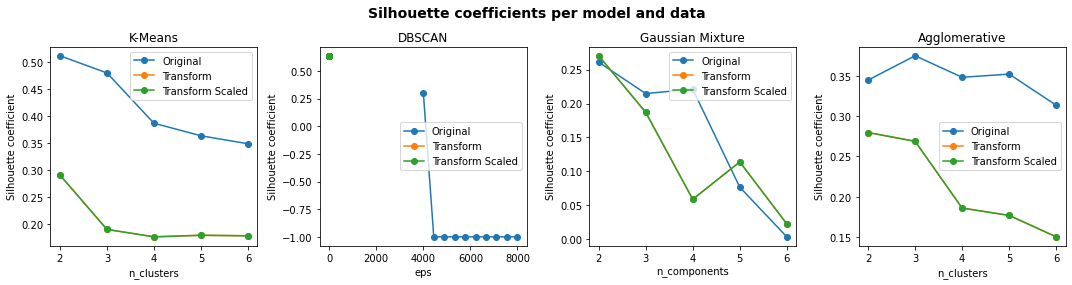

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15,4))

for dataset_name, models_data in tunning_results.items():

  for index, (model_name, results) in enumerate(models_data.items()):

    scores = results['Silhouette coefficients']
    
    x_ = [data[0] for data in scores]
    y_ = [data[1] for data in scores]

    param_name = list(params_grid[dataset_name][model_name].keys())[-1]

    axis = axs[index]

    axis.plot(x_, y_, '-o', label=dataset_name)
  
    axis.set_title(model_name)
    axis.set_xlabel(param_name)
    axis.set_ylabel('Silhouette coefficient')
    axis.legend()

fig.suptitle(f'Silhouette coefficients per model and data', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.show()

* Para el modelo `K-Means` el dataset `Original` muestra tener mejores resultados para todos los valores de clusters probados, siendo `n_clusters = 2` el punto más cercano a 1.

* Contrario a lo anterior, para los modelos `DBSCAN` y `Agglomerative`  los datasets `Transform` y `Transform Scaled` muestran mejor comportamiento.

* El modelo `Gaussian Mixture`, para los tres datasets, presenta un comportamiento similar.

* Para todos los casos, los resultados entre el dataset `Transform` y `Transform Scaled` son exactamente los mismos.

* El coeficiente de Silhouette promedio más alto obtenido esta por encima de 0.5 y se obtiene para los modelos `K-Means` y `DBSCAN`.

* Comparado con lo observado en la sección previa (*4. Validación de los modelos*) se encuentran combinaciones de parámetros para cada modelo que mejora los resultados obtenidos anteriormente.

### **5.2. Resultados**

Se procede a mostrar el listado de los modelos cuyos coeficiente son los más altos y los cercanos a él. Adicional, se muestra la cantidad de muestras mal agrupadas, es decir, la cantidad de coeficientes negativos.

In [ ]:
for dataset_name, models_dict in tunning_results.items():
  print('Dataset:', dataset_name)
  print('='*100)

  for model_name, model_data in models_dict.items():
    best_models = model_data['Best models']
    print(model_name)
    print('-'*len(model_name))

    for index, best_model in enumerate(best_models):
      dataset = summary['Data'][dataset_name]
      labels = best_model.fit_predict(dataset)

      if (labels < 0).any():
        dataset = dataset[labels >= 0]
        labels = labels[labels >= 0]

      # Checks that there is more that 1 cluster
      if len(np.unique(labels)) > 1:
        coefficients = silhouette_samples(dataset, labels)
        total_negatives = coefficients[coefficients<0].shape[0]
      else:
        total_negatives = -1

      print(f'  {index + 1}. {best_model}')
      print(f'     Total negative coefficients: {total_negatives}\n')

    print(' ')

  print('='*100, '\n\n')

Dataset: Original
K-Means
-------
  1. KMeans(n_clusters=2, random_state=23)
     Total negative coefficients: 18

 
DBSCAN
------
  1. DBSCAN(eps=4000.0, min_samples=16)
     Total negative coefficients: 29

 
Gaussian Mixture
----------------
  1. GaussianMixture(covariance_type='diag', n_components=2, random_state=23)
     Total negative coefficients: 74

 
Agglomerative
-------------
  1. AgglomerativeClustering()
     Total negative coefficients: 12

  2. AgglomerativeClustering(n_clusters=3)
     Total negative coefficients: 43

  3. AgglomerativeClustering(n_clusters=4)
     Total negative coefficients: 30

  4. AgglomerativeClustering(n_clusters=5)
     Total negative coefficients: 29

 


Dataset: Transform
K-Means
-------
  1. KMeans(n_clusters=2, random_state=23)
     Total negative coefficients: 6

 
DBSCAN
------
  1. DBSCAN(eps=1.0, min_samples=22)
     Total negative coefficients: 0

  2. DBSCAN(eps=1.1, min_samples=22)
     Total negative coefficients: 0

  3. DBSCAN(ep

* Para el dataset `Original` se observa que existen cuatro (4) modelos `Agglomerative`, siendo este el único con más de un algoritmo que presenta coeficientes de Silhouette promedio similares. Sin embargo, el mejor valor para `n_clusters` es de 2 (default) ya que presenta la mínima cantidad de muestras mal clasificadas (total valores negativos).

* Por otro lado, para los dataset `Transform` y `Transform Scaled` los modelos `DBSCAN` y `Agglomerative` contienen más de un algoritmo con coeficientes similares. Igualmente que el caso anterior, para los algoritmos `Agglomerative`,el valor para `n_clusters` con mejor resultado es 2. Sin embargo, para `DBSCAN` se conoce que los valores de `[1.0, 1.1, 1.2]`, para el parámetro `eps`, logran clasificar correctamente todos los valores.


Se procede a detallar las gráficas para los mejores modelos encontrados y ver el valor del coeficiente para cada muestra.

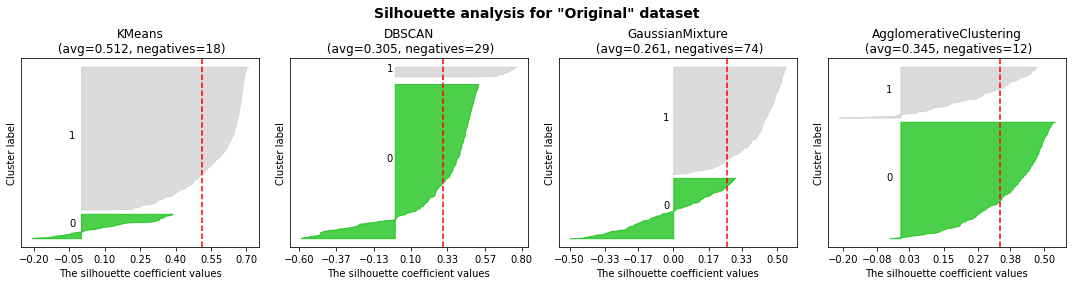

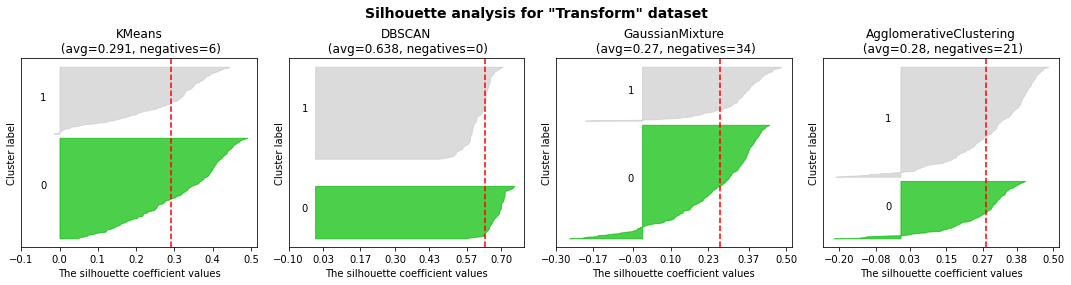

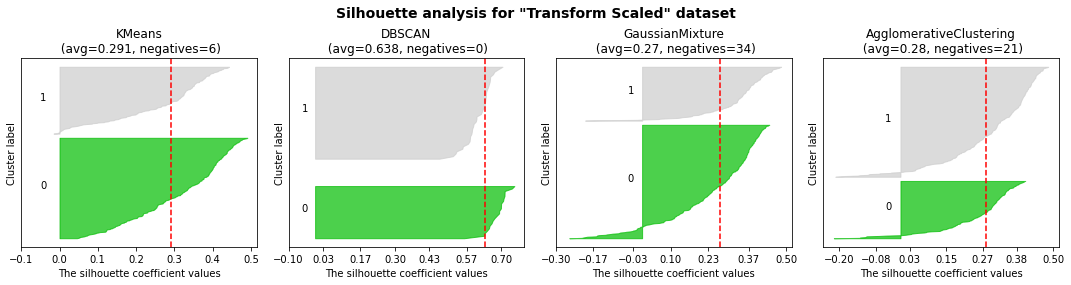

In [ ]:
for dataset_name, models_dict in tunning_results.items():
  dataset = summary['Data'][dataset_name]

  models = []
  for model_name, model_data in models_dict.items():
    models.append(model_data['Best models'][0])

  fig, axs = plt.subplots(1, len(models), figsize=(15,4))
  for index, model in enumerate(models):
    
    labels = model.fit_predict(dataset)

    silhouette_plot(X=dataset,
                    labels=labels, 
                    model=model, 
                    axis=axs[index])

  fig.suptitle(f'Silhouette analysis for "{dataset_name}" dataset', fontsize=14, fontweight="bold")

  plt.tight_layout()
  plt.subplots_adjust(top=0.8)
  plt.show()

* El modelo `DBSCAN`, para los datasets `Transform` y `Transform Scaled` logra obtener el coeficiente promedio mas alto (0.638) y una mínima cantidad de valores mal agrupados (0).

### **5.3. Pairplot**

Se eligen los dos mejores modelos según los resultados del ajuste de parámetros.

1. **Transform:** `DBSCAN(eps=1.0, min_samples=22)`
2. **Transform:** `KMeans(n_clusters=2, random_state=23)`
3. **Original:** `AgglomerativeClustering()`

In [ ]:
def pair_grid_plot(dataset_name, model_name, outliers=False):

  final_model = tunning_results[dataset_name][model_name]['Best models'][0]
  data_clustered = customers.copy()
  labels = final_model.labels_.astype(int)

  data_clustered['Cluster'] =  labels
  num_samples_clustered = labels[labels >= 0].shape[0]

  # Whether to plot or not the clusters labeled as -1
  if outliers and (-1 in labels):
    color_list = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628"]
    colors = {}
    for index, label in enumerate(labels):
      colors[label] = color_list[label] if label >= 0 else '#000000'
  else:
    colors = sns.color_palette("tab10", n_colors=len(np.unique(labels[labels >= 0])))
    data_clustered = data_clustered[data_clustered['Cluster'] >= 0]

  # print(f'Total samples: {num_samples_clustered}, Not clustered: {customers.shape[0] - num_samples_clustered}')
  chart = sns.PairGrid(data_clustered, corner=True, hue='Cluster', palette=colors)
  chart.map(sns.scatterplot)
  chart.add_legend()
  chart.fig.suptitle((f'{dataset_name} - {model_name}\nTotal samples: '
                     f'{num_samples_clustered}, Not clustered: '
                     f'{customers.shape[0] - num_samples_clustered}'),
                     fontsize=14, fontweight="bold")
  plt.show()

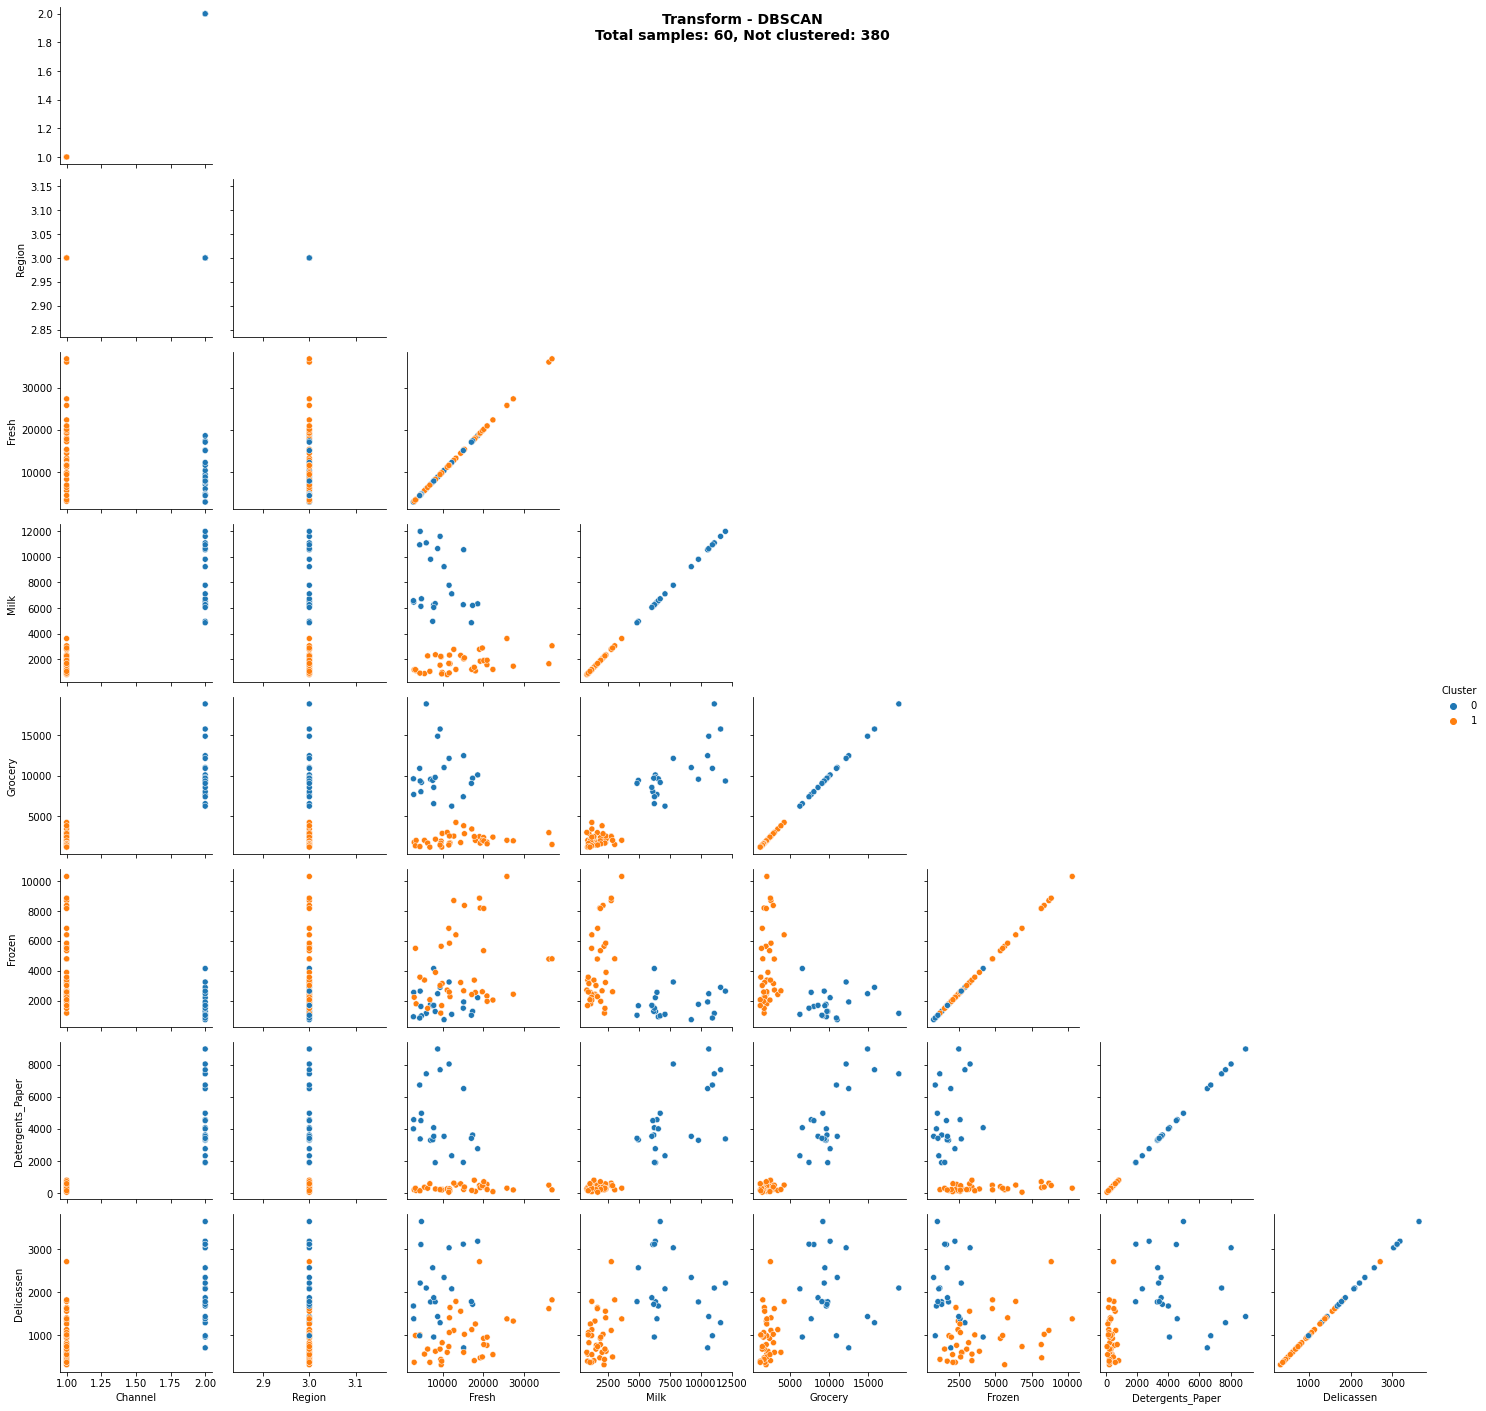

In [ ]:
pair_grid_plot(dataset_name='Transform', model_name='DBSCAN')

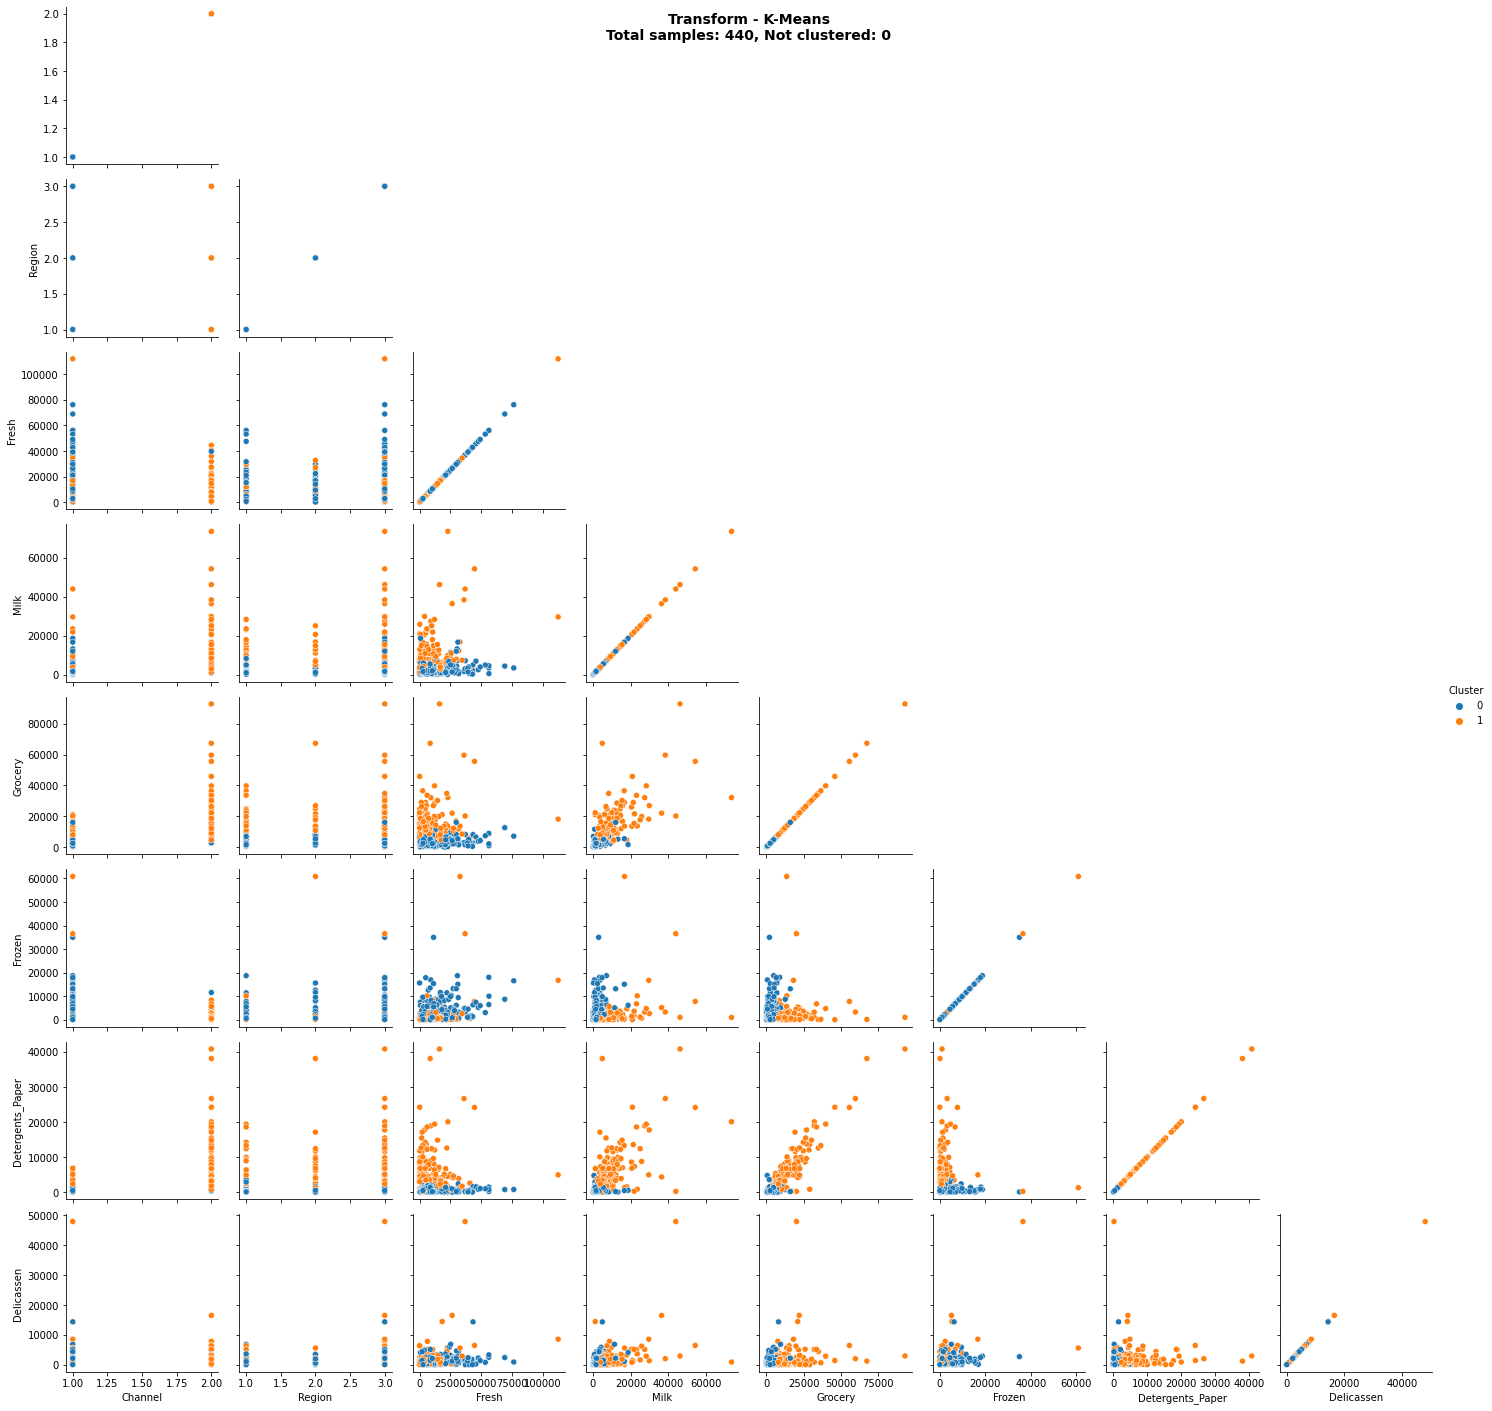

In [ ]:
pair_grid_plot(dataset_name='Transform', model_name='K-Means')

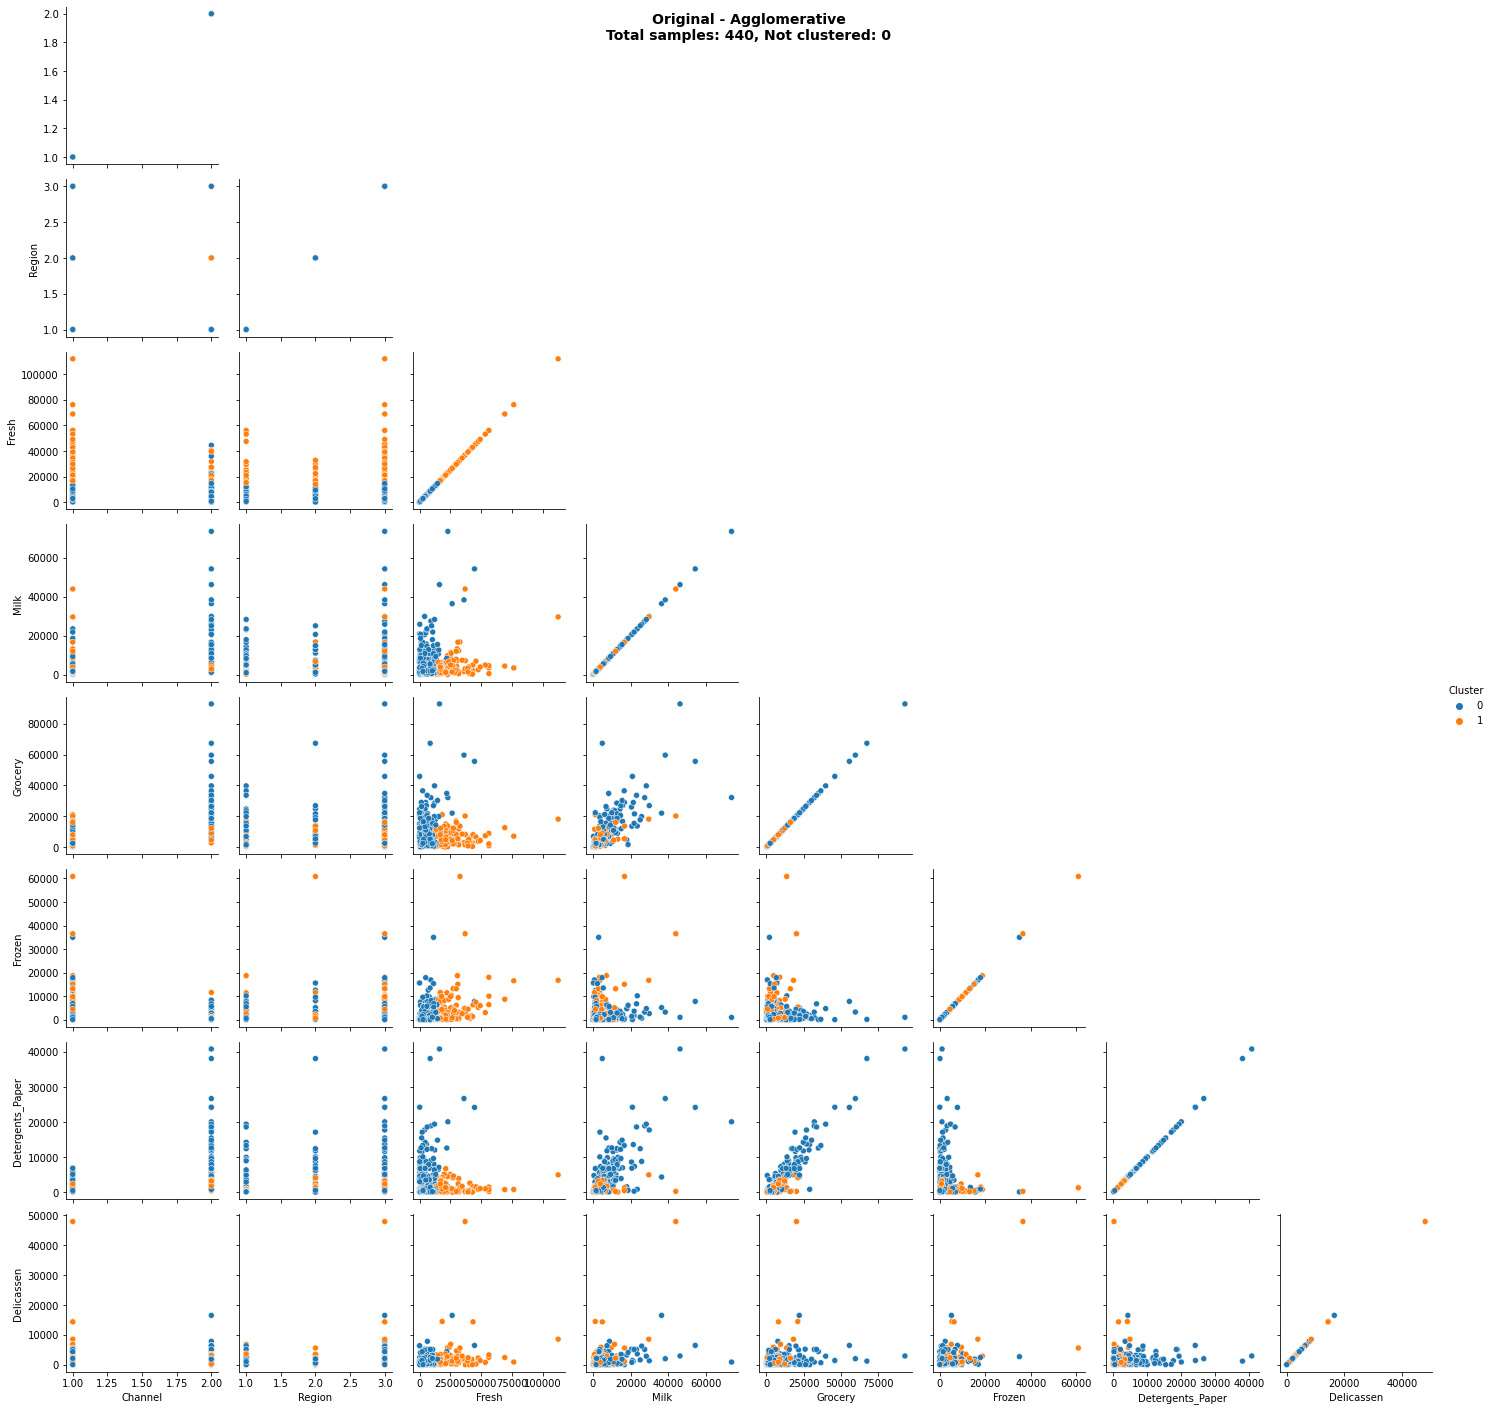

In [ ]:
pair_grid_plot(dataset_name='Original', model_name='Agglomerative')

## **6. Análisis de clientes**

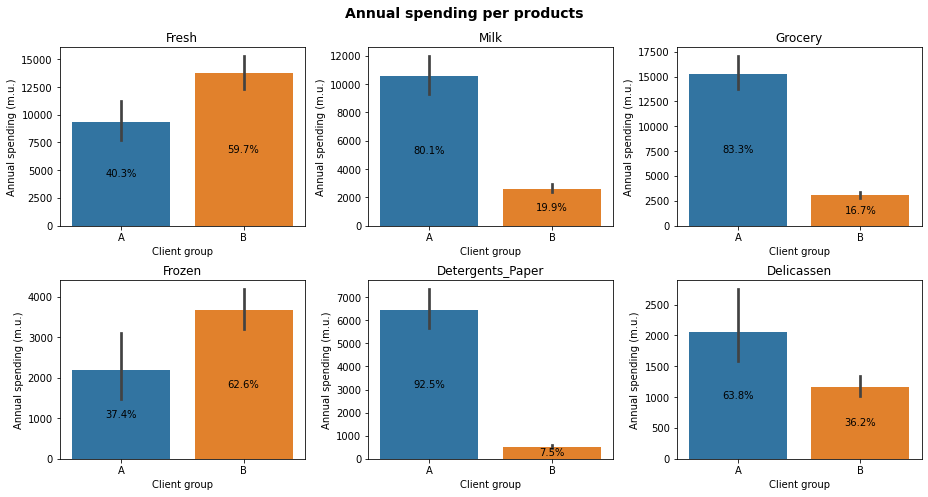

In [ ]:
final_model = tunning_results['Transform']['K-Means']['Best models'][0]
data_clustered = customers.copy()
labels = final_model.labels_.astype(int)
data_clustered['Cluster'] =  labels
data_clustered['Cluster'] = data_clustered['Cluster'].replace({0:'B', 1: 'A'})



fig = plt.figure(figsize=(13,7))

# Skip 'Channel', 'Region' and 'Cluster' columns
plot_columns = data_clustered.columns[2:-1]

# Get number of rows to plot all columns in `plot_columns` 
# in a grid plot with 3 columns
cols = 3
rows = len(plot_columns) // cols
rows += 1 if (len(plot_columns) % cols > 0) else 0

for index, column in enumerate(plot_columns):
  ax = fig.add_subplot(rows, cols, index + 1)

  sns.barplot(data=data_clustered, 
              x='Cluster', y=column,  
              ci=95, estimator=np.mean, ax=ax)

  # show the values in the plot
  total = sum([p.get_height() for p in ax.patches])
  for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w/2., h/2.)
    percentage = round(h/total * 100, 1)
    ax.annotate(f'{percentage}%', xy=xy, ha='center', va='center')
  
  ax.set_title(column)
  ax.set_ylabel('Annual spending (m.u.)')    
  ax.set_xlabel('Client group')

fig.suptitle(f'Total annual spending per products', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

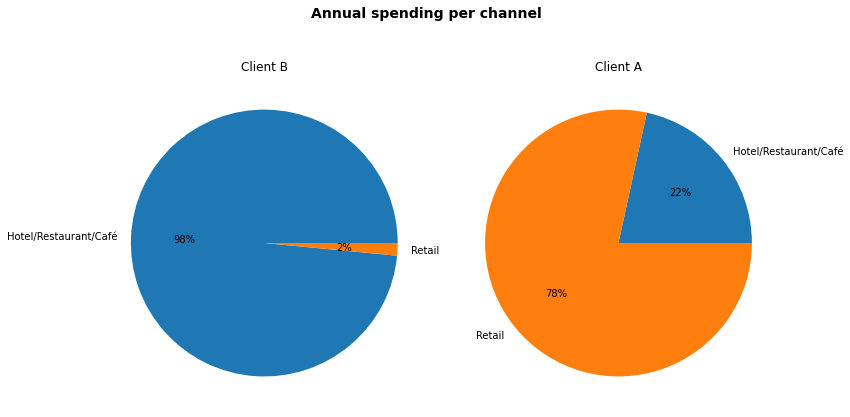

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,7))

channels = ['Hotel/Restaurant/Café', 'Retail']
clients = {0:'B', 1: 'A'}

for index, label in enumerate(np.unique(labels)):
    
    label = clients[label]

    x_ = data_clustered.loc[data_clustered.values[:,-1] == label, 'Channel'].values

    axes[index].set_title(f'Client {label}')
    axes[index].pie(np.bincount(x_)[1:], 
                    labels=channels,
                    autopct='%.0f%%')

fig.suptitle(f'Annual spending per channel', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=1.0)
plt.show()

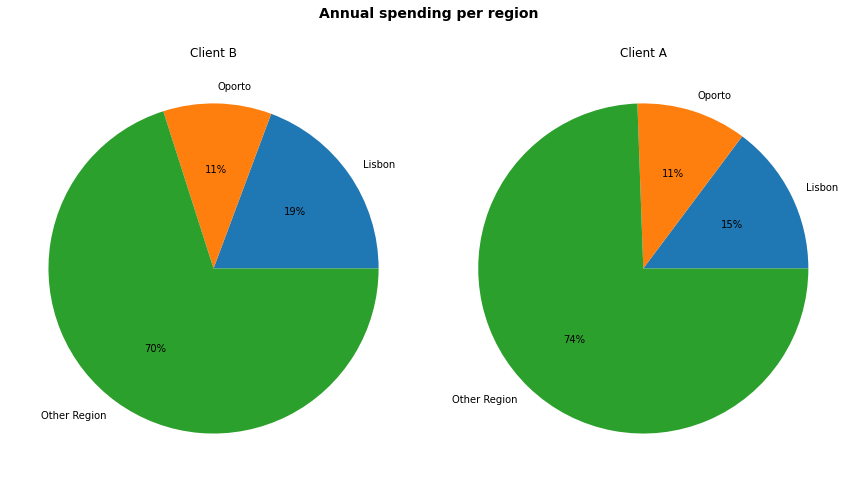

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,7))

regions = ['Lisbon', 'Oporto', 'Other Region']
clients = {0:'B', 1: 'A'}

for index, label in enumerate(np.unique(labels)):

  label = clients[label]

  x_ = data_clustered.loc[data_clustered.values[:,-1] == label, 'Region'].values

  axes[index].set_title(f'Client {label}')
  axes[index].pie(np.bincount(x_)[1:],
                  labels=regions, 
                  autopct='%.0f%%')

fig.suptitle(f'Annual spending per region', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

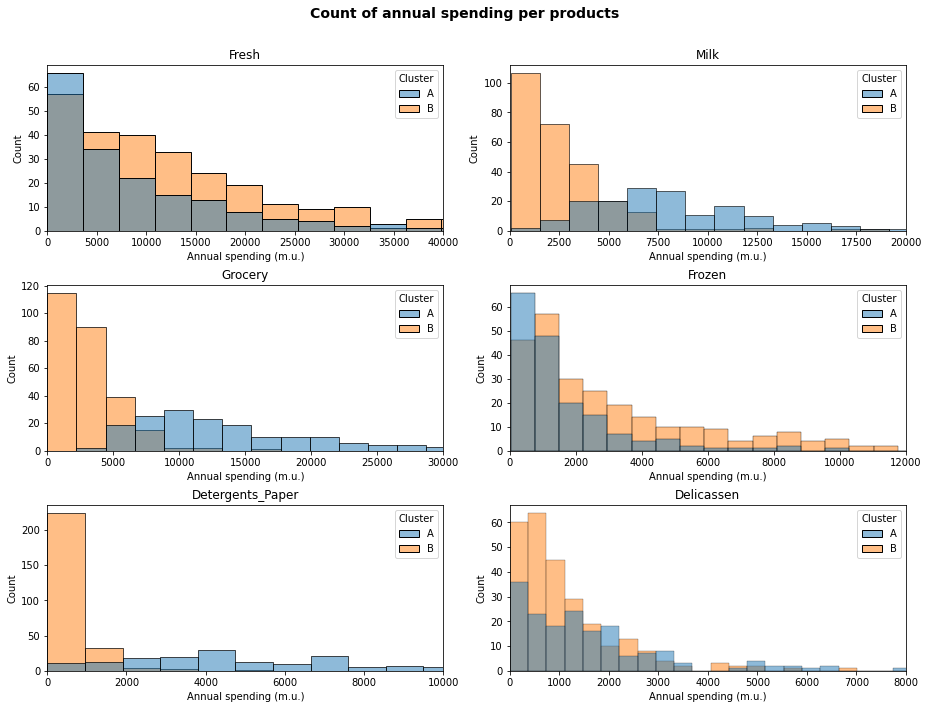

In [ ]:
from matplotlib.ticker import PercentFormatter

fig = plt.figure(figsize=(13,10))

# Skip 'Channel', 'Region' and 'Cluster' columns
plot_columns = data_clustered.columns[2:-1]

x_limits = [40000, 20000, 30000, 12000, 10000, 8000]

for index, column in enumerate(plot_columns):
  ax = fig.add_subplot(3, 2, index + 1)

  sns.histplot(data=data_clustered, 
               x=column, hue='Cluster', ax=ax)
  
  ax.set_title(column)
  ax.set_xlabel('Annual spending (m.u.)')   
  ax.set_xlim(left=0, right=x_limits[index])
  # ax.yaxis.set_major_formatter(PercentFormatter())

fig.suptitle(f'Count of annual spending per products', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

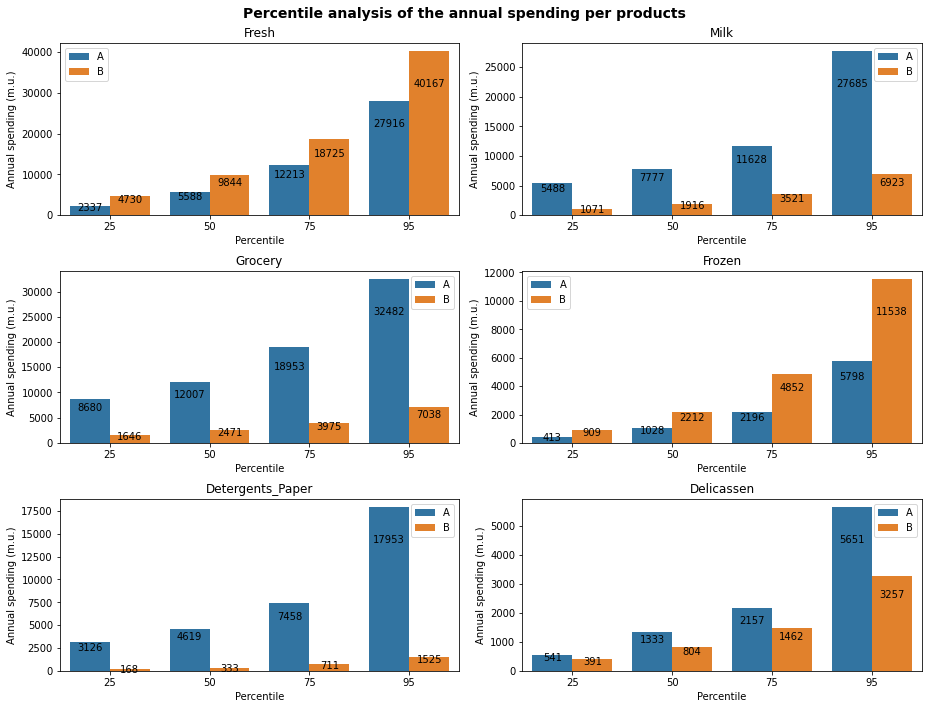

In [ ]:
fig = plt.figure(figsize=(13,10))

percentiles = [25, 50, 75, 95]

# Cluster values
clusters = data_clustered['Cluster'].unique()

# Skip 'Channel', 'Region' and 'Cluster' columns
plot_columns = data_clustered.columns[2:-1]

for index, column in enumerate(plot_columns):
  ax = fig.add_subplot(3, 2, index + 1)

  # Percentile values for each cluster in `column`
  perc_values = []

  # Cluster of the percentile calculated
  perc_cluster = []

  # Calculates percentiles for each cluster
  for cluster in clusters:
    data = data_clustered.loc[data_clustered['Cluster'] == cluster, column]
    values = [int(np.percentile(data, percentile)) for percentile in percentiles]
    perc_values += values
    perc_cluster += [cluster] * len(percentiles)

  color_labels = [[cluster]*len(percentiles) for cluster in clusters]
  sns.barplot(x=percentiles*len(clusters), y=perc_values, hue=perc_cluster, ax=ax)
  
  # show the values in the plot
  for p in ax.patches:
      h, w, x = p.get_height(), p.get_width(), p.get_x()
      xy = (x + w/2., h * 0.8)
      ax.annotate(str(int(h)), xy=xy, ha='center', va='center')

  ax.set_title(column)
  ax.set_xlabel('Percentile')
  ax.set_ylabel('Annual spending (m.u.)')

fig.suptitle(f'Percentile analysis of the annual spending per products', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

**Clientes A**

  - En el año gastan más dinero en productos detergentes y papel (92.5%), seguido por comestibles (83.3%) y lacteos (80.1%).

  - Los productos en lo que menos gastan dinero al año son congelados (37.4%) y frescos (40.3%).

  - El 78% del gasto anual de realiza en ventas minoristas.

  - El gato anual, de la mayoria (95%), en unidades monetarias, para cada tipo de producto, se encuentra por debajo de los siguientes valores:

<center>

| **Tipo de producto** 	| **Valor** 	|
|----------------------	|-----------	|
| Frescos              	| \$27.916   	|
| Lacteos              	| \$27.685   	|
| Comestibles          	| \$32.482   	|
| Congelados           	| \$5.798    	|
| Detergentes y papel  	| \$17.953   	|
| Charcuteria          	| \$5.651    	|

</center>

**Clientes B**

  - Gastan anualmente más dinero en productos congelados (62.6%) y frescos (59.7%) respecto al valor total vendido por categoria.

  - Los pordcutos detergentes y papel son en lo que menos gastan anualamente con un 7.5% del valor total vendido para esa categoria.

  - Aproximadamente todo el gasto anual (98%) proviene de ventas en hoteles, restaurantes o cafes.

  - El gato anual, de la mayoria (95%), en unidades monetarias, para cada tipo de producto, se encuentra por debajo de los siguientes valores:

<center>

| **Tipo de producto** 	| **Valor** 	|
|----------------------	|-----------	|
| Frescos              	| \$40.167  	|
| Lacteos              	| \$6.923   	|
| Comestibles          	| \$7.038   	|
| Congelados           	| \$11.538  	|
| Detergentes y papel  	| \$1.525   	|
| Charcuteria          	| \$3.257   	|

</center>

<br>

Se observa además que el gasto anual tanto para los clientes A y B es mayormente en otras regiones (alrededor del 70% y 74%), mientras que para las regiones de Oporto y Lisbon se tiene un gasto del 11% y entre 15% y 19% respectivamente.

# **Conclusiones**

* En la sección `2. Preparación de los datos` se transforma y escala el dataset basado en la distribución observada graficamente. Existen otros métodos en los cuales se pueden basar la decisión como la prueba de `Kolmogórov-Smirnov` o `chi-cuadrado`.

* Para este laboratorio se tuvieron en cuenta en total cuatro algoritmos de agrupamiento: `K-Means`, `DBSCAN`, `Gaussian Mixture` y `Agglomerative`. Sin embargo, estos fueron elegido de manera arbitraria y sin tener muy en cuenta la aplicación dada. Otros algoritmos de este tipo, implementados en Scikit-Learn pueden ser encontrados en su [guia sobre clustering](https://scikit-learn.org/stable/modules/clustering.html#).

* Si bien, el parámetro para evaluar el comportamiento de los algoritmos fue el coeficiente de Silhouette, existen otras métricas que permiten lograr este objetivo de manera supervisada o no. Algunas implementaciones en Scikit-Learn se pueden ver en su sección [Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

* Ya que la estimación de algunos parámetros se basa en el método del codo (`elbow method`), la selección del punto de mayor curvatura (`elbow point`) se realiza de forma aproximada a paritr de la visualización de las gráficas. Sin embargo, esto se puede mejorar iterando sobre combinaciones de valores ligeramente por encima y por debajo de el `elbow point` para determinar el que mejor se ajuste.

# Links relacionados

- [Clustering in Machine Learning | Google Developers](https://developers.google.com/machine-learning/clustering/workflow)

- [Clustering algorithms | Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#)

- [Principal clustering algorithms | Blog](https://www.freecodecamp.org/news/8-clustering-algorithms-in-machine-learning-that-all-data-scientists-should-know/)

- [Silhouette, validating clustering models | Youtube](https://www.youtube.com/watch?v=DpRPd274-0E)

- [Clustering Data with mixed types of features | Blog](https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b)

- [Elbow method in K-Means | Geeks for Geeks](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

- [Visualizing Clusters | Blog](https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489)

- [Implementación de DBSCAN en python | Blog](http://exponentis.es/ejemplo-de-uso-de-dbscan-en-python-para-deteccion-de-outliers)

- [Seaborn pairplot diagonal color | Stackoverflow](https://stackoverflow.com/questions/62617588/change-the-seaborn-pairplot-diagonal-color)

- [Seaborn pairplot, diagonal data | Stackoverflow](https://stackoverflow.com/questions/65345377/proper-diagonal-y-axes-for-seaborn-pairplot)